In [60]:
# Install the missing optuna-integration package
%pip install optuna-integration

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
import warnings
from pandas.errors import PerformanceWarning
warnings.simplefilter("ignore", PerformanceWarning)

import optuna
import time
from functools import partial

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import re
import time

from optuna_integration import LightGBMPruningCallback
import lightgbm as lgb
import json
import onnxruntime as ort

In [62]:
url = 'https://raw.githubusercontent.com/DanhBitoo/HanoiDaily-temperature/refs/heads/main/Hanoi%20Daily.csv'
df_daily = pd.read_csv(url)
df_daily.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hanoi,2015-01-01,24.0,11.4,17.7,24.0,11.4,17.7,9.4,63.8,...,17.1,7,NaN,2015-01-01T06:33:34,2015-01-01T17:26:18,0.36,Clear,Clear conditions throughout the day.,clear-day,"48820099999,48823099999,48825099999,48831099999,VVNB,remote"
1,Hanoi,2015-01-02,22.0,11.0,16.3,22.0,11.0,16.3,9.4,65.6,...,16.2,7,NaN,2015-01-02T06:33:53,2015-01-02T17:26:56,0.39,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,48831099999,VVNB"
2,Hanoi,2015-01-03,21.0,13.1,17.0,21.0,13.1,17.0,12.4,75.6,...,9.9,4,NaN,2015-01-03T06:34:11,2015-01-03T17:27:34,0.43,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"48820099999,48823099999,48825099999,48831099999,VVNB"
3,Hanoi,2015-01-04,22.6,16.9,19.3,22.6,16.9,19.3,16.1,82.0,...,5.6,3,NaN,2015-01-04T06:34:28,2015-01-04T17:28:12,0.46,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance of rain throughout the day.,rain,"48820099999,48823099999,48825099999,48831099999,VVNB"
4,Hanoi,2015-01-05,23.0,18.5,20.4,23.0,18.5,20.4,18.4,88.4,...,7.9,4,NaN,2015-01-05T06:34:44,2015-01-05T17:28:51,0.50,Overcast,Cloudy skies throughout the day.,cloudy,"48820099999,48823099999,48825099999,48831099999,VVNB"


# **Step 2**

## **Explain the meaning and values in each column**

| Feature Name | Description | Unit |
| :--- | :--- | :--- |
| name | The name of the location being recorded. | N/A (Text) |
| datetime | The specific date for the weather record. | N/A (Date/Time) |
| tempmax | The maximum temperature recorded for the day. | °C |
| tempmin | The minimum temperature recorded for the day. | °C |
| temp | The average temperature for the day. | °C |
| feelslikemax | The maximum "feels like" temperature, accounting for humidity and wind. | °C |
| feelslikemin | The minimum "feels like" temperature. | °C |
| feelslike | The average "feels like" temperature for the day. | °C |
| dew | The dew point temperature. This is the temperature at which air becomes saturated with water vapor. | °C |
| humidity | The average relative humidity for the day. | % |
| precip | The total amount of precipitation (e.g., rain) measured. | mm |
| precipprob | The probability of precipitation occurring on that day. | % |
| precipcover | The percentage of the day that precipitation was observed. | % |
| preciptype | The type(s) of precipitation observed. Can be a single value or a list. | N/A (Text) |
| snow | The amount of snowfall recorded. | mm |
| snowdepth | The depth of snow on the ground. | mm |
| windgust | The maximum wind gust speed recorded. | km/h |
| windspeed | The average wind speed for the day. | km/h |
| winddir | The average wind direction for the day (0-360), where 0/360 is North. | degrees (°) |
| sealevelpressure | The average sea-level atmospheric pressure. | mb |
| cloudcover | The average percentage of the sky covered by clouds. | % |
| visibility | The average visibility distance. | km |
| solarradiation | The average amount of solar radiation received. | W/m² |
| solarenergy | The total solar energy for the day. | MJ/m² |
| uvindex | The maximum UV (ultraviolet) index for the day on a scale from 0 upwards. | N/A (Scale) |
| severerisk | A rating of the risk for severe weather events (e.g., thunderstorms) on a scale. | N/A (Scale) |
| sunrise | The time of sunrise on that day. | N/A (Time) |
| sunset | The time of sunset on that day. | N/A (Time) |
| moonphase | The phase of the moon on a scale from 0 to 1 (0 is New Moon, 0.5 is Full Moon). | N/A (Scale) |
| conditions | A brief, comma-separated summary of the weather conditions for the day. | N/A (Text) |
| description | A more detailed, human-readable sentence describing the day's weather. | N/A (Text) |
| icon | A short text string representing a weather icon for use in applications. | N/A (Text) |
| stations | A list of weather station IDs that contributed data for that day's record. | N/A (List) |

## **Plot the target column (Hanoi temperature)**

In [63]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])
df_daily = df_daily.sort_values('datetime')

In [64]:
df_daily['temp'].isnull().sum()

np.int64(0)

### **Line Plot: Hanoi temperature trends by day for the last 10 years**

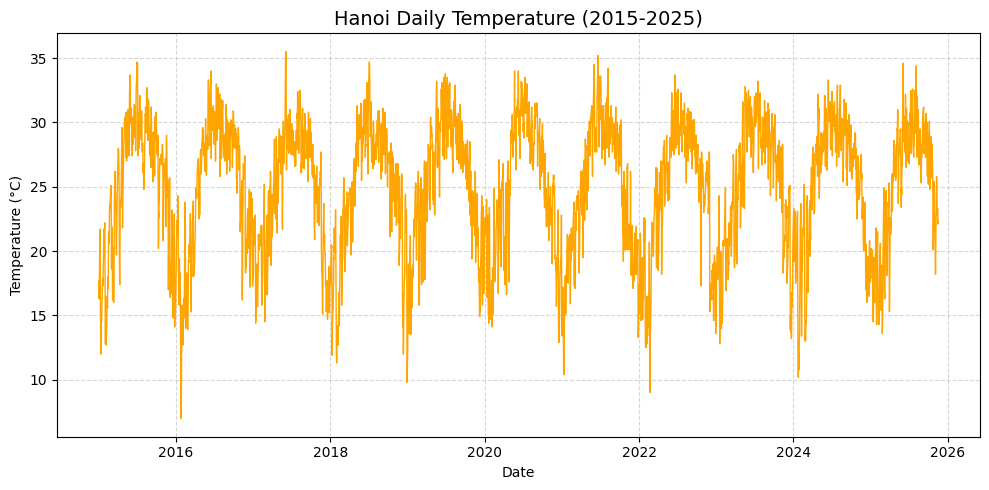

In [65]:
plt.figure(figsize=(10,5))
plt.plot(df_daily['datetime'], df_daily['temp'], color='orange', linewidth=1)
plt.title("Hanoi Daily Temperature (2015-2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observation:**

- The chart exhibits clear seasonal cycles, which reflect Hanoi’s tropical monsoon climate:
    + Temperature rises sharply during summer (May-August).
    + Drops noticeably during winter (December-February).
- The repeating up-and-down pattern shows strong yearly seasonality.
- There is no clear long-term increase or decrease, but several unusually high peaks appear in recent years, possibly due to urban heat and climate change.

**Evaluation:**

→ This plot is highly meaningful for understanding short-term (daily) variations and seasonal patterns, but not ideal for identifying long-term trends due to the high data density.

* Very important for analyzing time cycles (seasonality).Forecasting models (e.g., LSTM, Prophet, ARIMA) need to understand that temperature repeats in yearly cycles.

* Helps detect short-term trends, seasonal patterns, and unusual fluctuations (spikes).

(Limitation: If the data is too detailed, it needs further processing (rolling mean, resampling) before training.)

→ This is the most useful chart for training a time-based weather prediction model.

### **Line Plot + Bar Plot: Hanoi's average temperature trends by year for the last 10 years**

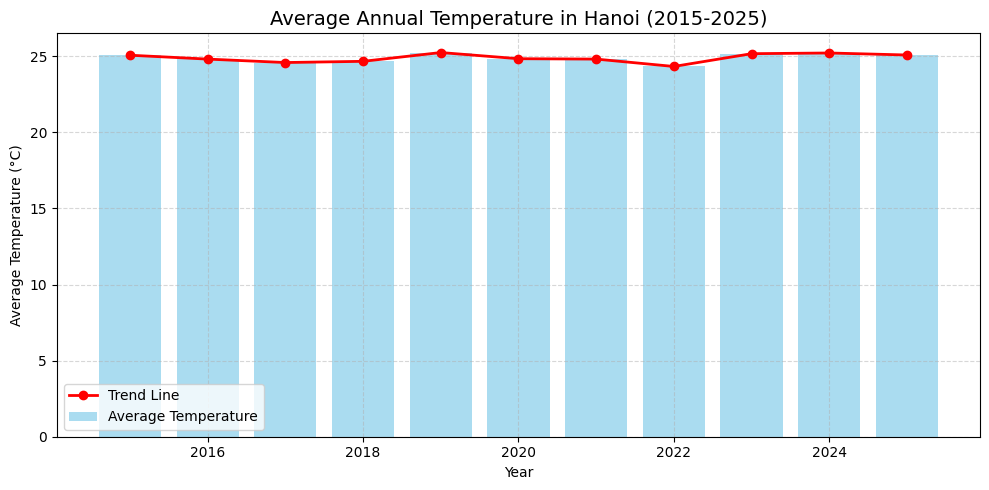

    year       temp
0   2015  25.074247
1   2016  24.819126
2   2017  24.592877
3   2018  24.672603
4   2019  25.249863
5   2020  24.844262
6   2021  24.819452
7   2022  24.334795
8   2023  25.174795
9   2024  25.220765
10  2025  25.088715


In [66]:
# Compute average temperature per year
yearly_avg = (
    df_daily.groupby(df_daily['datetime'].dt.year)['temp']
    .mean()
    .reset_index()
    .rename(columns={'datetime': 'year'})
)

# Plot line + bar chart to show long-term trend
plt.figure(figsize=(10, 5))
plt.bar(yearly_avg['year'], yearly_avg['temp'], color='skyblue', alpha=0.7, label='Average Temperature')
plt.plot(yearly_avg['year'], yearly_avg['temp'], color='red', marker='o', linewidth=2, label='Trend Line')

plt.title("Average Annual Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(yearly_avg)

**Observation:**

- The average annual temperature stays around 24.8–25.2 °C, showing very little change across the 10 years.
- Minor fluctuations occur, with slightly higher averages in 2019 and 2024, but the overall trend remains stable.

**Evaluation:**

This chart is the most informative for analyzing long-term (yearly) trends.

The bars show each year’s specific value, while the red line visualizes the overall direction of change.

It is highly recommended for inclusion in the report’s Data Understanding or Trend Analysis section.

### **Line Plot: Hanoi's average monthly temperature for the last 10 years**

C:\Users\Admin\AppData\Local\Temp\ipykernel_8352\1011380788.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


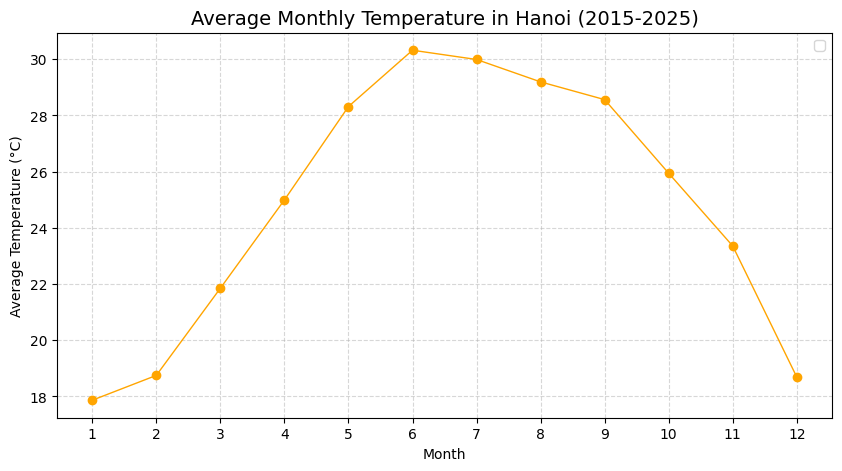

In [67]:
monthly_avg = df_daily.groupby(df_daily['datetime'].dt.month)['temp'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='orange', linewidth=1)
plt.title("Average Monthly Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**Observation**

From the Average Monthly Temperature plot, the temperature progression across months displays a well-defined seasonal cycle.
- The lowest temperatures occur in January and February, averaging around 18–19°C, which corresponds to the winter months in northern Vietnam.
- Temperatures begin to rise sharply in March and April, signaling the transition to spring and early summer.
- The hottest months are June and July, with mean temperatures reaching approximately 30–31°C, occasionally even higher on certain days.
- After July, the temperature gradually decreases through August to November, marking the autumn period.
- By December, the temperature drops back to around 19°C, completing the yearly cycle.

**Evaluation**

This pattern indicates a strong thermal seasonality, with roughly a 12°C difference between the coldest and hottest months, emphasizing the distinct contrast between Hanoi’s hot and humid summers and its mild but cool winters.

### **Bar Plot: Hanoi's average seasonal temperature for the last 10 years**

In [68]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

C:\Users\Admin\AppData\Local\Temp\ipykernel_8352\3439092894.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_avg.index, y=season_avg.values, palette='coolwarm')


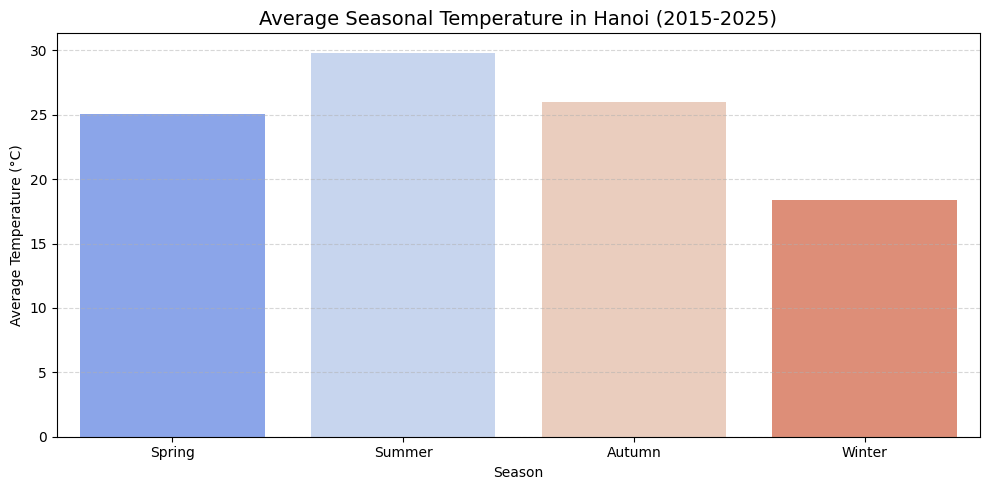

In [69]:
season_series = df_daily['datetime'].dt.month.map(get_season)
season_avg = df_daily.groupby(season_series)['temp'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

plt.figure(figsize=(10, 5))
sns.barplot(x=season_avg.index, y=season_avg.values, palette='coolwarm')
plt.title("Average Seasonal Temperature in Hanoi (2015-2025)", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Average Temperature (°C)")
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

**Observation**

The Average Temperature by Season chart provides further confirmation of these trends:
- Summer (Jun – August) is by far the hottest period, with an average temperature close to 30°C.
- Winter (December – February) is the coolest season, with an average around 20°C.
- Spring (March - May) and Autumn (September – November) are transitional periods, showing moderate temperatures of approximately 22 – 28°C, offering relatively comfortable weather conditions.

**Evaluation**

This clear temperature distinction between seasons highlights Hanoi’s typical monsoonal pattern, influenced by both continental cold air masses in winter and maritime tropical airflows in summer.

### **Rolling mean of Hanoi temperature (30-day Window) for the last 10 years**

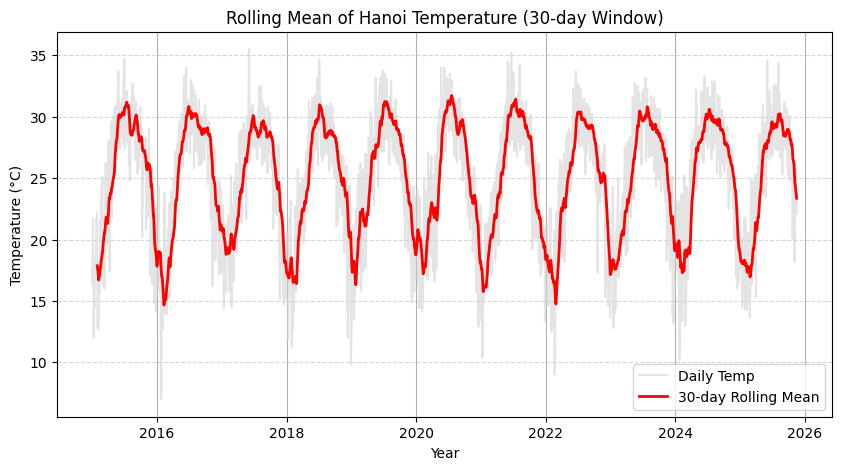

In [70]:
rolling_temp = df_daily['temp'].rolling(window=30).mean()

plt.figure(figsize=(10,5))
plt.plot(df_daily['datetime'], df_daily['temp'], color='lightgray', alpha=0.6, label='Daily Temp')
plt.plot(df_daily['datetime'], rolling_temp, color='red', label='30-day Rolling Mean', linewidth=2)
plt.title('Rolling Mean of Hanoi Temperature (30-day Window)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.grid(True)
plt.show()

The 30-day Rolling Mean Plot illustrates the temperature variation over time, smoothed to highlight broader trends while filtering out daily fluctuations. Each year exhibits a consistent pattern, peaking every summer and dipping every winter.

Notably:
- There is no significant long-term upward or downward trend in the average temperature over the 10-year period.
- This indicates that, while annual temperature cycles remain stable, short-term anomalies (such as unusually hot summers or mild winters) occasionally appear, but they do not accumulate into a persistent trend.

## **Relationship between different features of weather**

In [71]:
# Select only numeric columns for correlation matrix
numeric_df = df_daily.select_dtypes(include=["float64", "int64"])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()
corr_matrix

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
tempmax,1.000000,0.908425,0.977552,0.964663,0.888304,0.954556,0.842947,0.009376,0.056117,0.067619,...,0.153355,0.178022,-0.830672,-0.351379,0.421649,0.703680,0.703431,0.670665,0.629221,-0.002094
tempmin,0.908425,1.000000,0.969263,0.909332,0.962977,0.941512,0.932622,0.225392,0.131028,0.248611,...,0.154120,0.129666,-0.871838,-0.073481,0.350411,0.489328,0.489019,0.459874,0.630014,0.005367
temp,0.977552,0.969263,1.000000,0.957536,0.942184,0.974364,0.902398,0.098889,0.089841,0.147436,...,0.151617,0.158954,-0.870047,-0.231524,0.405314,0.622065,0.621803,0.587439,0.642399,0.000107
feelslikemax,0.964663,0.909332,0.957536,1.000000,0.899181,0.978870,0.866032,0.096276,0.100045,0.139900,...,0.180023,0.139832,-0.867703,-0.264368,0.440823,0.656549,0.656179,0.621372,0.745798,0.002693
feelslikemin,0.888304,0.962977,0.942184,0.899181,1.000000,0.951481,0.871678,0.139875,0.079368,0.185165,...,0.141742,0.116186,-0.851943,-0.109555,0.387759,0.536531,0.536255,0.491433,0.654755,0.005768
feelslike,0.954556,0.941512,0.974364,0.978870,0.951481,1.000000,0.876130,0.085772,0.075080,0.151750,...,0.155160,0.133513,-0.878882,-0.226213,0.447074,0.637368,0.637036,0.592740,0.730615,-0.000239
dew,0.842947,0.932622,0.902398,0.866032,0.871678,0.876130,1.000000,0.515282,0.191652,0.363968,...,0.143032,0.110944,-0.877275,0.013466,0.161374,0.373707,0.373276,0.352908,0.635491,0.006098
humidity,0.009376,0.225392,0.098889,0.096276,0.139875,0.085772,0.515282,1.000000,0.274324,0.537371,...,0.020746,-0.048569,-0.302878,0.474643,-0.449512,-0.363071,-0.363546,-0.344938,0.233626,0.015436
precip,0.056117,0.131028,0.089841,0.100045,0.079368,0.075080,0.191652,0.274324,1.000000,0.205776,...,0.161000,0.043344,-0.203796,0.164183,0.029834,-0.186789,-0.186916,-0.176833,0.062660,0.004093
precipprob,0.067619,0.248611,0.147436,0.139900,0.185165,0.151750,0.363968,0.537371,0.205776,1.000000,...,0.147126,-0.036053,-0.244419,0.432735,-0.090338,-0.328981,-0.329245,-0.320851,0.192064,0.006179


In [72]:
# Display top correlations (absolute value > 0.7 for example)
high_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix.abs() < 1)]
high_corr.dropna(how="all", inplace=True)
high_corr

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
tempmax,NaN,0.908425,0.977552,0.964663,0.888304,0.954556,0.842947,NaN,NaN,NaN,...,NaN,NaN,-0.830672,NaN,NaN,0.703680,0.703431,NaN,NaN,NaN
tempmin,0.908425,NaN,0.969263,0.909332,0.962977,0.941512,0.932622,NaN,NaN,NaN,...,NaN,NaN,-0.871838,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,0.977552,0.969263,NaN,0.957536,0.942184,0.974364,0.902398,NaN,NaN,NaN,...,NaN,NaN,-0.870047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feelslikemax,0.964663,0.909332,0.957536,NaN,0.899181,0.978870,0.866032,NaN,NaN,NaN,...,NaN,NaN,-0.867703,NaN,NaN,NaN,NaN,NaN,0.745798,NaN
feelslikemin,0.888304,0.962977,0.942184,0.899181,NaN,0.951481,0.871678,NaN,NaN,NaN,...,NaN,NaN,-0.851943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feelslike,0.954556,0.941512,0.974364,0.978870,0.951481,NaN,0.876130,NaN,NaN,NaN,...,NaN,NaN,-0.878882,NaN,NaN,NaN,NaN,NaN,0.730615,NaN
dew,0.842947,0.932622,0.902398,0.866032,0.871678,0.876130,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.877275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sealevelpressure,-0.830672,-0.871838,-0.870047,-0.867703,-0.851943,-0.878882,-0.877275,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
solarradiation,0.703680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.999891,0.961710,NaN,NaN
solarenergy,0.703431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.999891,NaN,0.961464,NaN,NaN


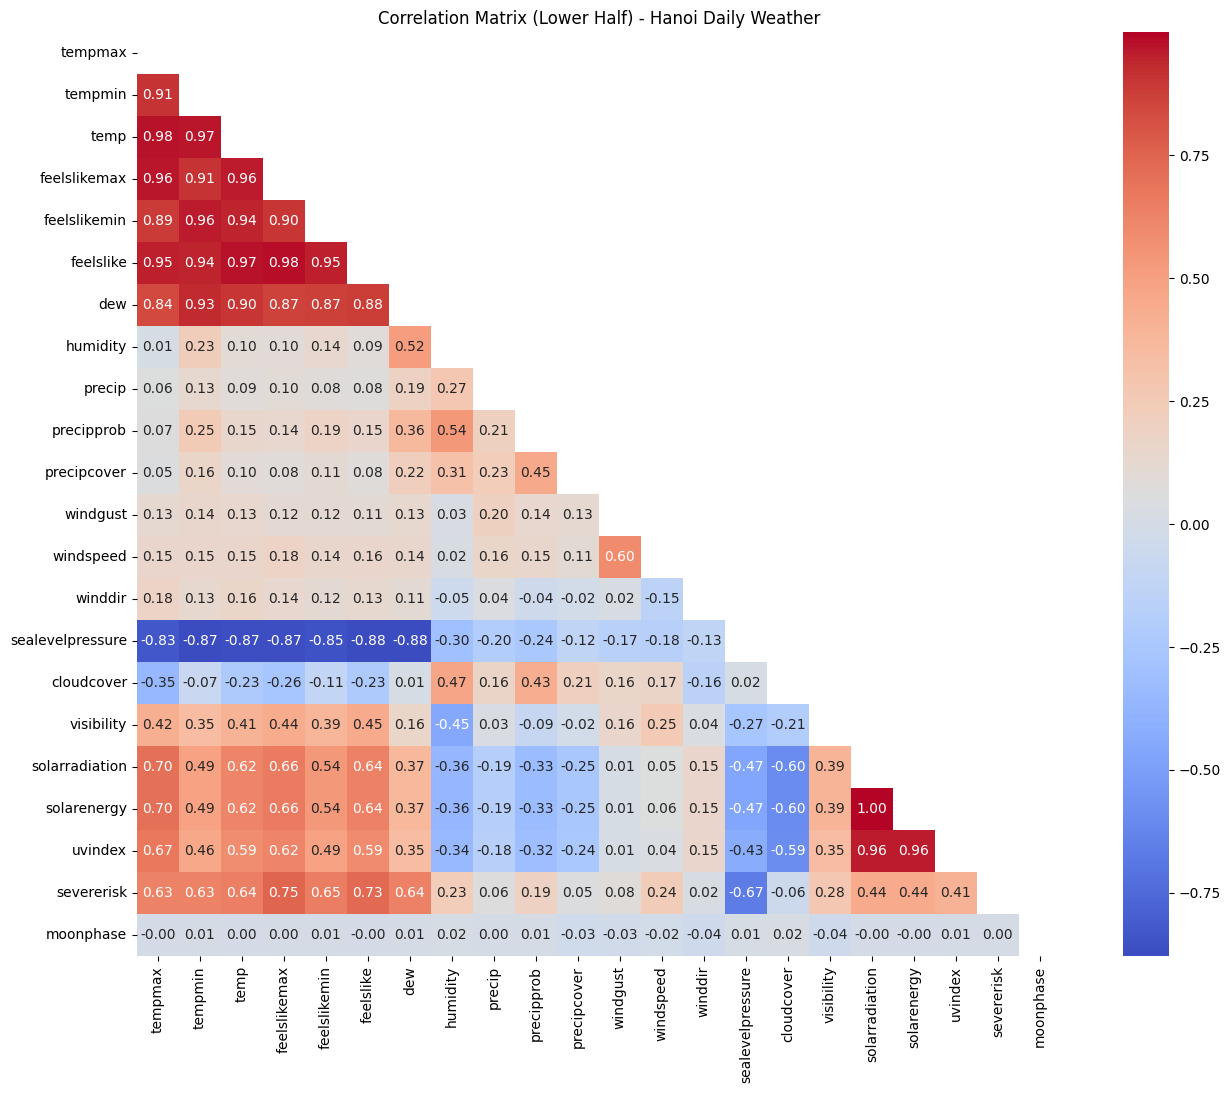

In [73]:
plt.figure(figsize=(16, 12))
numeric_cols = [col for col in numeric_df.columns if col not in ['snow', 'snowdepth']]
corr = df_daily[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            square=True)

plt.title('Correlation Matrix (Lower Half) - Hanoi Daily Weather')
plt.show()

## **Correlation Matrix Analysis – Hanoi Daily Weather Data**

### 1. Introduction  
The correlation matrix was computed on the numeric variables of the dataset `Hanoi Daily.csv`, including meteorological factors such as temperature, humidity, air pressure, solar radiation, and wind.  

The goal is to identify the **strength and direction of linear relationships** among variables, helping to select the most informative features for forecasting models or climate analysis.


### 2. Top correlated variable pairs (|r| > 0.7)

| Variable Pair | Correlation Coefficient | Relationship | Note |
|----------------|--------------------------|---------------|------|
| `tempmax` ↔ `temp` | **0.98** | Very strong, positive | As max temperature increases, mean temperature rises |
| `tempmin` ↔ `temp` | **0.97** | Very strong, positive | Strong linear relationship |
| `feelslikemax` ↔ `feelslike` | **0.98** | Very strong, positive | Perceived temperature closely matches actual temperature |
| `temp` ↔ `feelslike` | **0.97** | Very strong, positive | Highly redundant information |
| `dew` ↔ `humidity` | **≈0.90** | Very strong, positive | High humidity corresponds to high dew point |
| `solarradiation` ↔ `solarenergy` | **0.9999** | Almost identical | One can be dropped to reduce redundancy |
| `solarenergy` ↔ `uvindex` | **0.96** | Very strong, positive | Strong sunlight correlates with high UV index |
| `sealevelpressure` ↔ `temp` | **-0.87** | Strong, negative | Air pressure drops as temperature rises |



### 3. General observations  

- **Temperature group**

Variables `tempmax`, `tempmin`, `temp`, `feelslikemax`, and `feelslike` show very high correlations → they all capture the same physical phenomenon: **temperature variation**.  
Keep only one representative, such as `temp`.

- **Solar radiation group**

`solarradiation`, `solarenergy`, and `uvindex` are almost perfectly correlated.  
→ In modeling, keep just one (e.g., `solarenergy`) as a proxy for solar intensity.


- **Pressure vs. Temperature**

A strong negative correlation between `sealevelpressure` and temperature variables reflects basic atmospheric physics:  
→ When air warms up, it expands and pressure drops — often leading to unstable weather conditions (rain, storms, or wind).



- **Rainfall, Wind and Clouds**

Variables like `precip`, `windspeed`, `cloudcover`, and `visibility` have weak correlations with temperature variables → they are independent features capturing unique weather aspects.  
→ Keep all of them to improve predictive model performance.


### 4. Conclusions  
- The correlation matrix reveals potential multicollinearity among meteorological features.  
- It’s advisable to remove or combine variables with correlations above 0.9 to avoid redundancy.  
- Independent groups such as precipitation, wind, and cloud cover remain essential for **forecasting extreme weather events**.  

## **How variables combine to detect or predict Hanoi temperature**

### 1. Overview  
The temperature in Hanoi can be estimated or predicted by combining several strongly related meteorological variables.  
Based on the correlation matrix, the temperature (`temp`) shows strong or moderate relationships with **humidity, dew point, air pressure, solar radiation, and wind** — all of which influence the daily thermal conditions.

### 2. Key influencing variables

In [74]:
latest_date = df_daily['datetime'].max()
start_date = latest_date - pd.DateOffset(years= 1)
df_last_year = df_daily[df_daily['datetime'] >= start_date].copy()

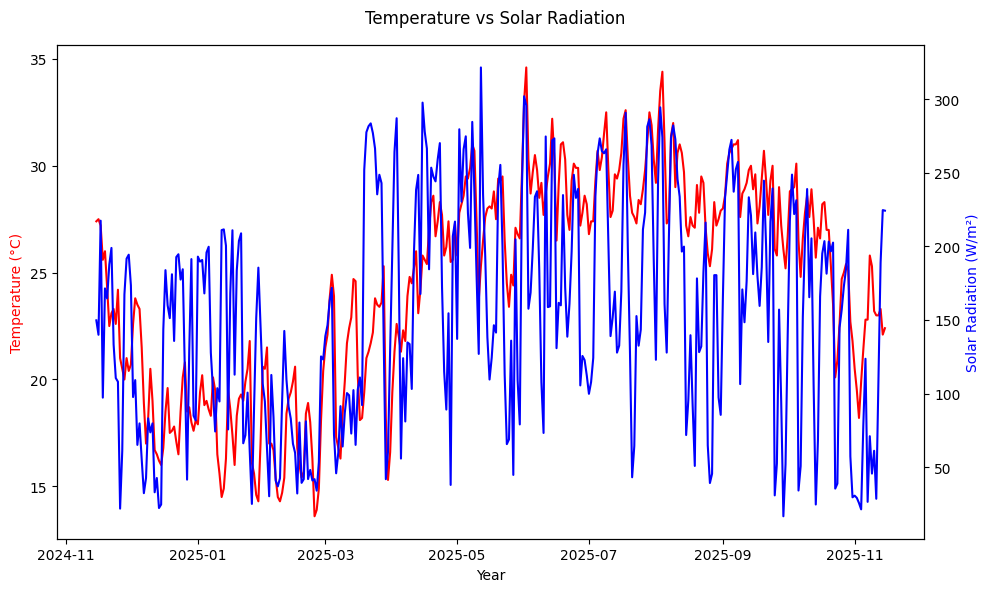

In [75]:

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['solarradiation'], color='blue', label='Solar Radiation')
ax2.set_ylabel('Solar Radiation (W/m²)', color='blue')

fig.suptitle('Temperature vs Solar Radiation')
fig.tight_layout()
plt.show()

###  **Solar Radiation and UV Index**  
- Variables: `solarradiation`, `solarenergy`, `uvindex`  
- These have the strongest **positive correlation** with temperature.  
- More solar radiation → higher surface heating → higher temperature.  
- In predictive modeling, these variables explain **daytime warming**.

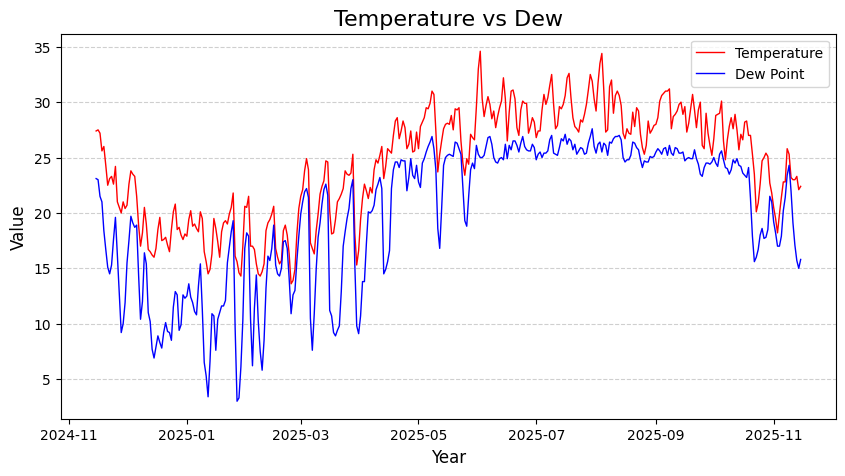

In [76]:
plt.figure(figsize=(10, 5))

plt.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature', linewidth=1)

plt.plot(df_last_year['datetime'], df_last_year['dew'], color='blue', label='Dew Point', linewidth=1)


plt.title('Temperature vs Dew', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

plt.show()

###  **Humidity and Dew Point**  
- Variables: `humidity`, `dew`  
- **Moderate to strong positive correlation**.  
- High humidity means the air contains more moisture, which traps heat and increases the perceived temperature (`feelslike`).  
- Useful for predicting **nighttime and early-morning temperature stability**.
- The dew point is useful measure of humidity:
    + Higher dew point = more moisture in the air, making it feel humid and sticky.
    + Lower dew point = clean air, often making conditions feel more comfortable.

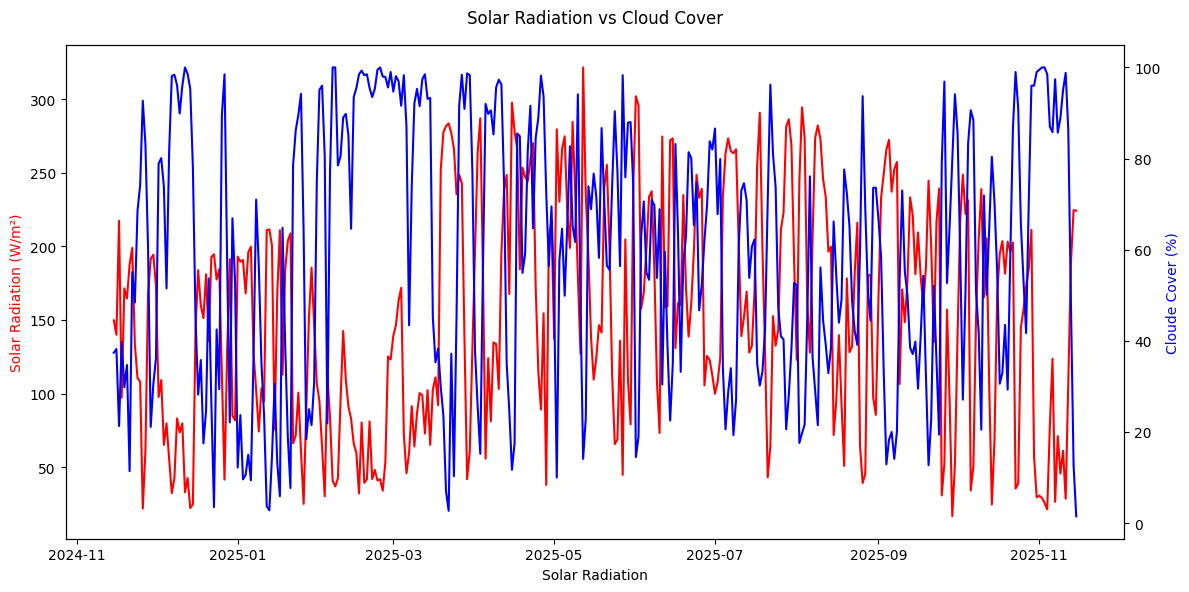

In [77]:

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_last_year['datetime'], df_last_year['solarradiation'], color='red', label='Solar Radiation')
ax1.set_xlabel('Solar Radiation')
ax1.set_ylabel('Solar Radiation (W/m²)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['cloudcover'], color='blue', label='Cloud Cover')
ax2.set_ylabel('Cloude Cover (%)', color='blue')

fig.suptitle('Solar Radiation vs Cloud Cover')
fig.tight_layout()
plt.show()

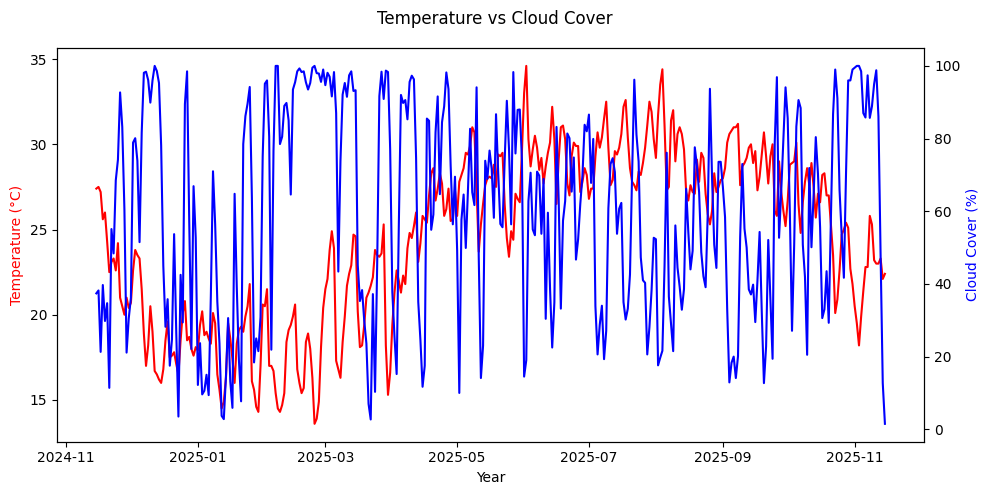

In [78]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['cloudcover'], color='blue', label='Cloud Cover')
ax2.set_ylabel('Cloud Cover (%)', color='blue')

fig.suptitle('Temperature vs Cloud Cover')
fig.tight_layout()
plt.show()

###  **Cloud Cover and Visibility**  
- Variables: `cloudcover`, `visibility`  
- **Inverse relation** with solar radiation.  
- More clouds → less sunlight reaching the ground → cooler daytime temperature.  
- Often used together with solar variables to correct for **radiation blocking** effects.
- Cloud Cover and Visibility can be good measure of each other:
    + Lower Cloud Cover = Higher Visibility
    + Higher Cloud Cover = Lower Visibility
    + For example, if the cloud cover is high, it means that the sunlight is blocked, humidity and moisture can be high which lead to low visibility and vice versa.

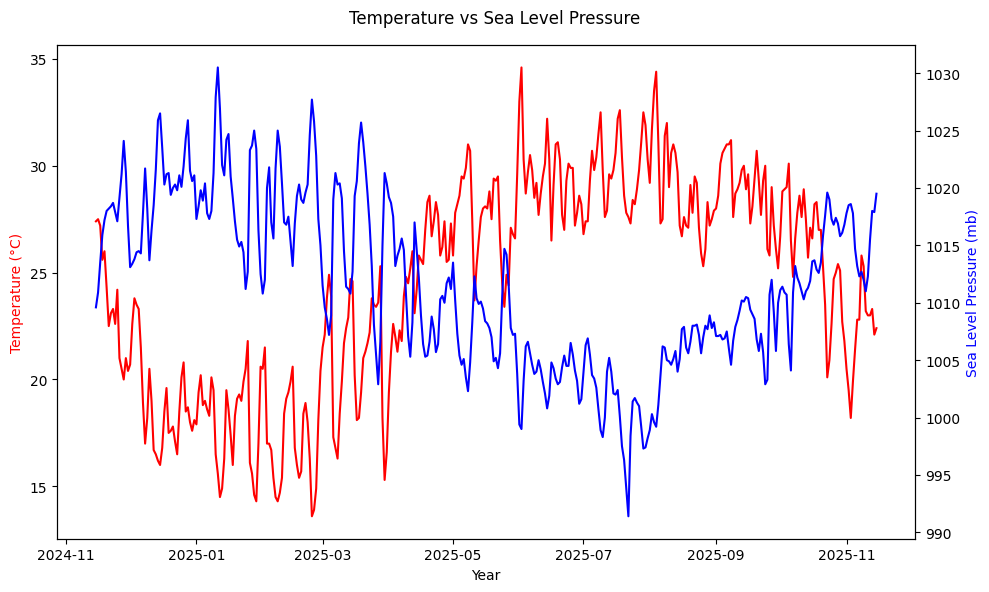

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_last_year['datetime'], df_last_year['temp'], color='red', label='Temperature')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='red')

ax2 = ax1.twinx()
ax2.plot(df_last_year['datetime'], df_last_year['sealevelpressure'], color='blue', label='Sea Level Pressure')
ax2.set_ylabel('Sea Level Pressure (mb)', color='blue')

fig.suptitle('Temperature vs Sea Level Pressure')
fig.tight_layout()
plt.show()

###  **Air Pressure**  
- Variable: `sealevelpressure`  
- **Strong negative correlation (≈-0.87)** with temperature.  
- When temperature rises, air expands and pressure drops.  
- This variable is useful for identifying **weather pattern transitions** (e.g., hot low-pressure systems).


### 3. Combined Predictive Structure  

Temperature can be modeled as a function of several predictors:

$$
T = f(\text{Solar Radiation},\ \text{Humidity},\ \text{Air Pressure},\ \text{Cloud Cover},\ \text{Wind})
$$


In practice, these relationships can be captured through:
- **Multiple Linear Regression** for linear effects  
- **Random Forest or Gradient Boosting** for nonlinear interactions  
- **Time-series models** (e.g., LSTM, Prophet) to account for seasonal and diurnal patterns  


### 4. Summary  

| Variable Group | Relationship to Temperature | Role in Detection |
|----------------|------------------------------|-------------------|
| Solar radiation & UV | Positive | Main driver of heating |
| Humidity & Dew point | Positive | Moisture-driven heat retention |
| Air pressure | Negative | Inverse physical response |
| Cloud cover & Visibility | Negative | Controls sunlight penetration |
| Wind | Mixed | Regulates surface heat dispersion |

**In conclusion:**  
By integrating solar intensity, humidity, air pressure, cloud cover, and wind data, we can effectively detect and forecast temperature variations in Hanoi.  
These factors jointly represent the **energy balance of the atmosphere**, which directly governs how hot or cold a day becomes.


# **Step 3**

## **Determine feature type**

In [80]:
df_daily.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [81]:
# Convert data type for datetime columns
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'], errors='coerce')
df_daily['sunrise']  = pd.to_datetime(df_daily['sunrise'], errors='coerce')
df_daily['sunset']   = pd.to_datetime(df_daily['sunset'], errors='coerce')

In [82]:
df_daily = df_daily.set_index('datetime').sort_index()

In [83]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3972 entries, 2015-01-01 to 2025-11-15
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              3972 non-null   object        
 1   tempmax           3972 non-null   float64       
 2   tempmin           3972 non-null   float64       
 3   temp              3972 non-null   float64       
 4   feelslikemax      3972 non-null   float64       
 5   feelslikemin      3972 non-null   float64       
 6   feelslike         3972 non-null   float64       
 7   dew               3972 non-null   float64       
 8   humidity          3972 non-null   float64       
 9   precip            3972 non-null   float64       
 10  precipprob        3972 non-null   int64         
 11  precipcover       3972 non-null   float64       
 12  preciptype        2912 non-null   object        
 13  snow              3972 non-null   int64         
 14  snowde

## **Handle missing value**

In [84]:
# Check columns with missing values
nan_counts = df_daily.isnull().sum()
cols_with_nan = nan_counts[nan_counts > 0]
cols_with_nan

preciptype    1060
severerisk    2566
dtype: int64

### **preciptype**

In [85]:
df_daily['preciptype'].value_counts(dropna=False)

preciptype
rain    2912
NaN     1060
Name: count, dtype: int64

**`preciptype`**: This column describes the type(s) of precipitation observed (e.g., rain, snow, sleet).  
- When no precipitation occurred, this field naturally remains **NaN**.  
- Moreover, since the dataset also includes the `precipprob` column (showing 0% if no precipitation occurred, or 100% if it did), there are two reasonable ways to handle these missing values:
  1. Replace NaN in `preciptype` with `'none'` to explicitly indicate the absence of precipitation.  
  2. Combine `preciptype` and `precipprob` into a new binary feature indicating **whether precipitation occurred or not** (e.g., `has_precip = 0/1`).

In [86]:
df_daily['preciptype'] = df_daily['preciptype'].fillna('none')
df_daily['preciptype'] = df_daily['preciptype'].replace({'rain': 1, 'none': 0})
df_daily['preciptype'].value_counts(dropna=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8352\3934160314.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_daily['preciptype'] = df_daily['preciptype'].replace({'rain': 1, 'none': 0})


preciptype
1    2912
0    1060
Name: count, dtype: int64

### **severerisk**

In [87]:
df_daily['severerisk'].value_counts(dropna=False)

severerisk
NaN      2566
10.0      771
30.0      258
60.0      249
75.0      106
100.0      11
5.0         5
15.0        3
8.0         3
Name: count, dtype: int64

In [88]:
df_daily['severerisk'].isnull().sum()/df_daily['severerisk'].shape[0]

np.float64(0.6460221550855992)

**`severerisk`**: This column represents the risk level of severe weather events (in %).  
- Missing values here likely indicate that **no severe weather risk was detected or forecasted** for those days.  
- It could be reasonable to fill NaN values with **0.0** to represent “no risk.”
- However, since over **65% of the entries are missing**, it should be considered to **drop this column entirely** to avoid introducing bias or excessive noise into the dataset.


In [89]:
df_daily.drop(columns=['severerisk'], inplace=True)

### **Encode categorical features using one-hot/label encoder**

Many columns in our dataset, such as `icon`, `conditions`, or `description` are categorical (text/ string) variables. Machine learning models (especially tree-based models like Random Forest) cannot directly work with text data—they require numerical representations. We evaluated the frequency and semantic meaning of each variable.

In [90]:
df_daily['icon'].value_counts()

icon
rain                 2859
partly-cloudy-day     828
clear-day             208
cloudy                 77
Name: count, dtype: int64

In [91]:
df_daily['conditions'].value_counts()

conditions
Rain, Partially cloudy    2319
Partially cloudy           828
Rain, Overcast             520
Clear                      208
Overcast                    77
Rain                        20
Name: count, dtype: int64

The `.value_counts()` function is used to analyze the unique values and their frequencies for each categorical feature:

For the `icon` variable, there are 4 distinct categories: `rain`, `partly-cloudy-day`, `clear-day` and `cloudy` each appearing a certain number of times in the dataset.

For the `conditions` variable, the categories are more descriptive, e.g.: Rain, Partially cloudy; Partially cloudy, Rain, Overcast, etc.

In [92]:
df_daily['description'].head(10)

datetime
2015-01-01                                          Clear conditions throughout the day.
2015-01-02                                             Partly cloudy throughout the day.
2015-01-03                                             Partly cloudy throughout the day.
2015-01-04    Partly cloudy throughout the day with a chance of rain throughout the day.
2015-01-05                                              Cloudy skies throughout the day.
2015-01-06                    Partly cloudy throughout the day with late afternoon rain.
2015-01-07       Cloudy skies throughout the day with rain in the morning and afternoon.
2015-01-08                         Partly cloudy throughout the day with afternoon rain.
2015-01-09                     Partly cloudy throughout the day with early morning rain.
2015-01-10     Cloudy skies throughout the day with a chance of rain throughout the day.
Name: description, dtype: object

For the `description` column (which contains daily weather summaries), we display the first few entries to understand the semantic content and diversity—these are longer text descriptions that may need advanced encoding techniques.

In [93]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3972 entries, 2015-01-01 to 2025-11-15
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              3972 non-null   object        
 1   tempmax           3972 non-null   float64       
 2   tempmin           3972 non-null   float64       
 3   temp              3972 non-null   float64       
 4   feelslikemax      3972 non-null   float64       
 5   feelslikemin      3972 non-null   float64       
 6   feelslike         3972 non-null   float64       
 7   dew               3972 non-null   float64       
 8   humidity          3972 non-null   float64       
 9   precip            3972 non-null   float64       
 10  precipprob        3972 non-null   int64         
 11  precipcover       3972 non-null   float64       
 12  preciptype        3972 non-null   int64         
 13  snow              3972 non-null   int64         
 14  snowde

## **Removing irrelevant or constant features**

### **Constant columns**

In [94]:
constant_cols = [col for col in df_daily.columns if df_daily[col].nunique() == 1]
display(constant_cols)

for col in constant_cols:
    print(df_daily[col].value_counts(), '\n')

['name', 'snow', 'snowdepth']

name
Hanoi    3972
Name: count, dtype: int64 

snow
0    3972
Name: count, dtype: int64 

snowdepth
0    3972
Name: count, dtype: int64 



In [95]:
df_daily.drop(columns=constant_cols, inplace=True)

The columns `name`, `snow`, and `snowdepth` are removed because they contain only a **single unique value** throughout the dataset:

- **`name`**: All records correspond to the same location (“Hanoi”), so this column provides no variability or additional information for analysis or prediction.  
- **`snow`** and **`snowdepth`**: Both columns contain only zeros, indicating that no snowfall events occurred in Hanoi during the entire observation period.  

Since these variables do not contribute any useful variation or predictive power, they are classified as **constant features** and therefore dropped from the dataset.

### **Irrelevant columns (non-informative columns)**

In [96]:
df_daily['stations'].value_counts()

stations
48820099999,48823099999,48825099999,48831099999,VVNB                                                           3507
VMI0000VVNB,48820099999,48825099999,VVNB,VMM00048825                                                            149
48820099999,48823099999,48825099999,48831099999,VVNB,remote                                                     100
VVNB                                                                                                             47
VMI0000VVNB,48820099999,48823099999,48825099999,VVNB,VMM00048825                                                 47
VMI0000VVNB,VMM00048823,VMM00048831,VVNB,VMM00048825                                                             28
VMI0000VVNB,48820099999,48823099999,48825099999,VMM00048823,VVNB,VMM00048825                                     16
48820099999,VVNB                                                                                                 13
48820099999,48823099999,48825099999,48831099999,remote,VVNB    

In [97]:
df_daily['stations'].nunique()

32

The `stations` column lists combinations of weather station IDs that contributed data for each record. Although it contains **32 unique combinations**, almost **90% of all rows (3507/3927) share the same main group** of stations (`48820099999,48823099999,48825099999,48831099999,VVNB`). The remaining combinations appear only a few times and represent slight variations of the same nearby stations.

This column does **not provide meaningful variability** or predictive information — all stations belong to the same city (Hanoi), and the small differences between station codes do not affect temperature, humidity, or precipitation patterns.

Moreover, the column consists of **complex multi-code strings**, making it impractical to encode for analysis or modeling. Since the dataset already includes the `name` column identifying the city, `stations` is **redundant and can be safely removed**.

In [98]:
pd.set_option('display.max_colwidth', None)
df_daily[['icon', 'conditions', 'description']].head(10)

,icon,conditions,description
datetime,,,
2015-01-01,clear-day,Clear,Clear conditions throughout the day.
2015-01-02,partly-cloudy-day,Partially cloudy,Partly cloudy throughout the day.
2015-01-03,partly-cloudy-day,Partially cloudy,Partly cloudy throughout the day.
2015-01-04,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance of rain throughout the day.
2015-01-05,cloudy,Overcast,Cloudy skies throughout the day.
2015-01-06,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with late afternoon rain.
2015-01-07,rain,"Rain, Overcast",Cloudy skies throughout the day with rain in the morning and afternoon.
2015-01-08,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoon rain.
2015-01-09,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with early morning rain.


Among the three columns — `icon`, `conditions`, and `description` — only **`conditions`** should be kept:

- **`icon`** provides short categorical codes (e.g., `"clear-day"`, `"rain"`, `"partly-cloudy-day"`) mainly used for visualization or UI purposes. It does not add meaningful analytical value.  
- **`description`** is a full-sentence narrative (e.g., “Partly cloudy throughout the day with afternoon rain.”) that conveys the same information as `conditions` but in a verbose, text-heavy format. It is redundant and not suitable for quantitative modeling.  
- **`conditions`** offers concise and interpretable categorical labels (e.g., “Clear”, “Rain, Overcast”) that effectively summarize the weather situation and can be easily encoded for machine learning or statistical analysis.

Therefore, **only the `conditions` column is retained**, while `icon` and `description` are removed as non-informative or redundant.


In [99]:
df_daily['preciptype'].value_counts()

preciptype
1    2912
0    1060
Name: count, dtype: int64


During the preprocessing stage, several columns were removed from the dataset because they provided limited predictive value, contained redundant information, or introduced unnecessary complexity. The removal was guided by the principles of **feature relevance**, **multicollinearity avoidance**, and **low-variance filtering** in data preparation for supervised learning.


| **Column**                                        | **Rationale for Removal**                                                                                                                                                                                                     |
| ------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **icon**, **description**                         | Contain text-based weather summaries that overlap semantically with the `conditions` feature. <br> <br> They add redundant categorical information with high cardinality, which is difficult to encode effectively for regression. |
| **stations**                                      | Represents weather station ID combinations. <br> <br> Nearly 90% of entries correspond to the same station group, providing negligible variability and minimal predictive power.                                                    |
| **solarenergy**, **moonphase**                    | `solarenergy` is physically correlated with `solarradiation`, leading to redundant representation of solar intensity. <br> <br> `moonphase` shows no meaningful correlation with temperature or other meteorological variables.     |
| **feelslike**, **feelslikemax**, **feelslikemin** | Apparent temperature values derived from actual temperature, humidity, and wind speed. <br> <br> Including them would cause multicollinearity and reduce interpretability.                                                         |
| **severerisk**                                    | Contains nearly constant values across all records, offering little statistical or predictive contribution.                                                                                                                    |
| **uvindex**                                       | Highly correlated with `solarradiation` and `cloudcover`.  <br><br> Removed to prevent redundant solar-related information.                                                                                                       |
| **preciptype**                                    | Describes precipitation type (mostly “rain” or null). <br> <br> Its low variability and categorical imbalance make it insignificant for regression tasks.                                                                          |


# **Step 4**

**Feature Engineering Process**
This process, executed by the create_all_features_ver2 function, aims to transform raw data into more meaningful features for a machine learning model, particularly for a time-series forecasting task.

The process consists of 5 main steps:

1. Time Features
This is the most fundamental step, extracting temporal information from the DataFrame's index (which is assumed to be a datetime object):

- year: The year.

- month: The month (e.g., 1, 2, ..., 12).

- day_of_year: The day number within the year (1-366).

- day_of_week: The day number within the week (0=Monday, 6=Sunday).

- quarter: The quarter of the year (1-4).

- season: The season (Winter, Spring, Summer, Autumn), mapped from the month.

2. Cyclical Feature Encoding
- Features like month, day of the week, and day of the year are cyclical (e.g., month 12 is very close to month 1, Sunday is very close to Monday). Using them as simple numbers (1-12) is misleading for a model, as it implies 12 is far from 1.

- The encode_cyclical function (not defined in the snippet, but inferred) is used to convert these features into two dimensions (Sine and Cosine).

- This helps the model understand the continuous, cyclical nature of time (e.g., the month_sin and month_cos values for December will be very close to those for January).

- The original columns (month, day_of_year, day_of_week, season) are then dropped to avoid redundant information.

3. Lag Features
- This is a critically important technique in time-series forecasting, allowing the model to "look back" at past values.

- The function iterates through a list of lag_features (e.g., 'temp', 'humidity') and a list of lags (e.g., [1, 7, 14]).

- It creates new columns like temp_lag1 (temperature from 1 day ago) and temp_lag7 (temperature from 7 days ago) using the .shift() method.

- This provides the model with information about the values of important features at previous time steps.

4. Rolling Window Features
- This technique helps capture recent trends and volatility.

- The function iterates through a list of roll_features and window sizes windows (e.g., [3, 7]).

- For each window (e.g., w=7), it calculates:

+ Mean (.mean()): e.g., temp_roll7_mean is the average temperature of the last 7 days (including the current day).

+ Standard Deviation (.std()): e.g., temp_roll7_std is the standard deviation of the temperature in the last 7 days, indicating volatility.

5. Derived Features
- This is the most "creative" part, where new features are engineered by combining existing ones based on domain knowledge—in this case, meteorology.

- Temperature Interactions:

    + temp_range: The diurnal temperature range (tempmax - tempmin).

    + dewpoint_depression: The difference between air temperature and dew point (temp - dew).

    + temp_diff: Difference between max temperature and current temperature.

    + Humidity & Pressure Interactions:

    + humidity_change: Change in humidity from the previous day (.diff()).

    + sealevelpressure_change: Change in sea level pressure from the previous day.

    + pressure_trend_3d: The 3-day pressure trend (.diff(3)).

    + humidity_sealevelpressure_ratio: Ratio of humidity to sea level pressure.

- Wind Interactions:

    + wind_speed_squared: Wind speed squared (may relate to kinetic energy).

    + wind_chill: An estimated wind chill index.

    + wind_ratio: Ratio of wind gust to average wind speed.

- Precipitation Interactions:

    + precip_flag: A binary flag (1 if it rained, 0 otherwise).

    + precip_effect / precip_expected_simple: Indices combining precipitation probability and amount.

- Solar & Energy:

    + day_length_hour: Calculated day length in hours based on sunrise and sunset times.

    + solar_per_hour: Solar energy normalized by the length of the day.

    + solar_expected_clear: Solar radiation adjusted for cloud cover.

- Complex Weather Indices:

    + severe_proxy: A proxy index for severe weather (combining rain probability and the rain flag).

    + severe_index: A composite index for severity, combining the severe_proxy with wind gust and cloud cover.

    + heat_index_approx: An approximate formula for the heat index.

6. Cleanup
In the final step, the function removes unnecessary columns to prepare the data for the model:

target_col: The target variable is dropped to prevent data leakage.


Other high-correlation columns: Columns like tempmax, tempmin, and sunrise, which were used to create derived features, are also dropped as they are no longer needed.

The function returns a df_new DataFrame containing only the engineered features, ready to be fed into the forecasting model.

In [100]:
RANDOM_STATE = 42
TARGET_COL   = 'temp'
HORIZON      = 5
LAGS         = [1,3,5,7]
ROLL_WINDOWS = [7,14,28,56,84]

LAG_COLS  = ['humidity','dew','precip','precipprob','precipcover','solarradiation',
             'sealevelpressure','windspeed','winddir','windgust','cloudcover','visibility']
ROLL_COLS = ['humidity','dew','precip','precipprob','precipcover','solarradiation',
             'sealevelpressure','windspeed','winddir','windgust','cloudcover','visibility']


def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

def create_all_features(df, target_col, horizon, lag_features, lags, roll_features, windows):
    df_new = df.copy()

    # 1. time features
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['quarter'] = df_new.index.quarter
    df_new['season'] = df_new['month'].map({
        12:"Winter",1:"Winter",2:"Winter",
        3:"Spring",4:"Spring",5:"Spring",
        6:"Summer",7:"Summer",8:"Summer",
        9:"Autumn",10:"Autumn",11:"Autumn"
    })

    # 2. cyclical
    df_new = encode_cyclical(df_new, 'month', 12)
    df_new = encode_cyclical(df_new, 'day_of_year', 366)
    df_new = encode_cyclical(df_new, 'day_of_week', 7)
    df_new = df_new.drop(columns=['month','day_of_year','day_of_week','season'], errors='ignore')

    # 3. lags
    for feature in lag_features:
        if feature in df_new.columns:
            for lag in lags:
                df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)

    # 4. rolling 
    for feature in roll_features:
        if feature in df_new.columns:
            for w in windows:
                rolling_window = df_new[feature].rolling(window=w)
                df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
                df_new[f'{feature}_roll{w}_std']  = rolling_window.std()

    # 5. derived features
    if 'tempmax' in df_new.columns and 'tempmin' in df_new.columns:
        df_new["temp_range"] = df_new["tempmax"] - df_new["tempmin"]
    if 'temp' in df_new.columns and 'dew' in df_new.columns:
        df_new["dewpoint_depression"] = df_new["temp"] - df_new["dew"]
    if 'tempmax' in df_new.columns and 'temp' in df_new.columns:
        df_new["temp_diff"] = df_new["tempmax"] - df_new["temp"]
    if 'humidity' in df_new.columns:
        df_new['humidity_change'] = df_new['humidity'].diff()
    if 'humidity' in df_new.columns and 'sealevelpressure' in df_new.columns:
        df_new["humidity_sealevelpressure_ratio"] = df_new["humidity"] / df_new["sealevelpressure"]
    if 'dew' in df_new.columns and 'humidity' in df_new.columns:
        df_new["dewpoint_humidity_ratio"] = df_new["dew"] / df_new["humidity"]
    if 'sealevelpressure' in df_new.columns:
        df_new["sealevelpressure_change"] = df_new["sealevelpressure"].diff()
    if 'cloudcover' in df_new.columns and 'sunrise' in df_new.columns:
        df_new["cloud_sunshine_ratio"] = df_new["cloudcover"] / (pd.to_datetime(df_new["sunrise"], errors='coerce').dt.hour + 1e-6)
    if 'windspeed' in df_new.columns:
        df_new["wind_speed_squared"] = df_new["windspeed"] ** 2
    if 'temp' in df_new.columns and 'windspeed' in df_new.columns:
        df_new["wind_chill"] = df_new["temp"] - (df_new["windspeed"] * 0.1)
    if {'windspeed','windgust'}.issubset(df_new.columns):
        df_new['wind_ratio'] = df_new['windgust'] / (df_new['windspeed'] + 1e-6)
    if 'sealevelpressure' in df_new.columns:
        df_new["pressure_trend_3d"] = df_new["sealevelpressure"].diff(3)
    if {'precipprob','precip'}.issubset(df_new.columns):
        df_new['precip_effect'] = df_new['precipprob'] * (df_new['precip'] + 1)
    if 'precipprob' in df_new.columns and 'precip' in df_new.columns:
        df_new["precip_expected_simple"] = df_new["precipprob"] * df_new["precip"]
    if 'sunrise' in df_new.columns and 'sunset' in df_new.columns:
        sr = pd.to_datetime(df_new['sunrise'], errors='coerce')
        ss = pd.to_datetime(df_new['sunset'], errors='coerce')
        valid = sr.notna() & ss.notna()
        df_new['day_length_hour'] = np.nan
        df_new.loc[valid, 'day_length_hour'] = (ss[valid] - sr[valid]).dt.total_seconds()/3600
    if 'solarenergy' in df_new.columns and 'day_length_hour' in df_new.columns:
        df_new["solar_per_hour"] = df_new["solarenergy"] / (df_new["day_length_hour"] + 1e-6)
    if 'solarradiation' in df_new.columns and 'cloudcover' in df_new.columns:
        df_new["solar_expected_clear"] = df_new["solarradiation"] * (1 - (df_new["cloudcover"]/100.0))
    if 'precipprob' in df_new.columns and 'precip_flag' in df_new.columns:
        df_new["severe_proxy"] = df_new["precipprob"] * df_new["precip_flag"]
    if {'severe_proxy','windgust','cloudcover'}.issubset(df_new.columns):
        df_new["severe_index"] = df_new["severe_proxy"] * (df_new["windgust"].fillna(0) + df_new["cloudcover"]/100.0)
    if {'temp','humidity','wind_speed_squared'}.issubset(df_new.columns):
        df_new["heat_index_approx"] = df_new["temp"] + 0.33*df_new["humidity"] - 0.70*np.sqrt(df_new["wind_speed_squared"]) - 4.00

    # 6. targets t+1..t+H
    for i in range(1, horizon+1):
        df_new[f'target_{target_col}_t+{i}'] = df_new[target_col].shift(-i)

    df_new = df_new.drop(columns=[target_col], errors='ignore')
    df_new = df_new.drop(columns=['tempmax','tempmin','temp','sunrise','sunset'], errors='ignore')
    return df_new


# **Step 5**


## 5.1 Custom Scaling Strategy: SmartLinearScaler

In [101]:
class SmartLinearScaler:
    """
    - log1p strong skew cols, not negative.
    - Do not log if:
        + cols' values already in [0,1] or [-1,1]
        + belongs to scale_candidates (4 cols)
    - /100 only for 4 scale_candidates columns if they are not normalized.
    - Keep schema as Train.
    """
    def __init__(self, skew_threshold=1.2, min_nonneg_ratio=0.98):
        self.skew_threshold = float(skew_threshold)
        self.min_nonneg_ratio = float(min_nonneg_ratio)

        self.columns_ = None
        self.log_cols_ = []

        self.scale_candidates = [
            'humidity', 'precipprob', 'precipcover', 'cloudcover'
        ]
        self.scale_cols_ = []

    def _pick_log_cols(self, X):
        log_cols = []
        for c in X.columns:
            s = pd.to_numeric(X[c], errors='coerce')

            if s.notna().sum() == 0:
                continue

            mn, mx = s.min(), s.max()


            if (mn >= 0 and mx <= 1) or (mn >= -1 and mx <= 1):
                continue

            if c in self.scale_candidates:
                continue

            if (s >= 0).mean() < self.min_nonneg_ratio:
                continue

            # large skew → log
            if abs(s.skew(skipna=True)) >= self.skew_threshold:
                log_cols.append(c)

        return log_cols

    def _pick_scale_cols(self, X):
        chosen = []
        for c in self.scale_candidates:
            if c not in X.columns:
                continue

            s = pd.to_numeric(X[c], errors='coerce')
            if s.notna().sum() == 0:
                continue

            mn, mx = s.min(), s.max()

            # No scale if already normalized
            if (mn >= 0 and mx <= 1) or (mn >= -1 and mx <= 1):
                continue

            chosen.append(c)

        return chosen

    def fit(self, X):
        Xn = X.select_dtypes(include=[np.number]).copy()
        self.columns_ = list(Xn.columns)

        self.log_cols_ = self._pick_log_cols(Xn)
        self.scale_cols_ = self._pick_scale_cols(Xn)

        return self

    def transform(self, X):
        X = X.copy()

        # convert numeric
        for c in X.columns:
            if not pd.api.types.is_numeric_dtype(X[c]):
                X[c] = pd.to_numeric(X[c], errors='coerce')

        for c in self.columns_:
            if c not in X.columns:
                X[c] = 0.0

        X = X[self.columns_]

        # 1) log transform
        for c in self.log_cols_:
            X[c] = np.log1p(X[c].astype(float).clip(lower=0))

        # 2) scale /100
        for c in self.scale_cols_:
            X[c] = X[c] / 100.0

        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In the data preprocessing stage for model training, we did not use traditional scalers such as `StandardScaler` or `MinMaxScaler`. Instead, we designed a custom transformer called **SmartLinearScaler**.

This scaler was created specifically for **weather time-series forecasting**, where different features have very different ranges, units, and statistical distributions (e.g., humidity %, precipitation probability %, solar radiation, wind speed, etc.).

The goals of the SmartLinearScaler are:

* Reduce **skewness** for heavily right-skewed variables by applying logarithmic transformation.
* Normalize **percentage-based variables** to the [0, 1] range.
* Leave already-normalized variables unchanged.
* Maintain a consistent **feature schema** between train/validation/test.
* Avoid **data leakage** by learning transformation rules **only** from the training set.

---

### 5.1.1 Concept and Motivation

The SmartLinearScaler implements the following rules:

1. **Log-transform (`log1p`)** is applied only to:

   * Columns that are non-negative (or almost non-negative).
   * Columns that have high skewness (|skew| ≥ threshold, default 1.2).

   → Purpose: reduce the effect of extreme values, stabilize variance, and help linear models perform better.

2. **Log-transform is NOT applied** when:

   * The column is already normalized to [0, 1] or [-1, 1].
   * The column belongs to the **percentage group** (`scale_candidates`), which will be handled by linear scaling instead.

3. **Linear scaling (/100)** is applied only to four percentage-like variables:

   ```
   humidity, precipprob, precipcover, cloudcover
   ```

   * Only applied if the column is *not* already in a normalized range.

   → For weather datasets, these variables are often originally measured in **percentage (%)**, so dividing by 100 standardizes them.

This yields a hybrid transformation strategy that is more appropriate than blindly applying a global scaler to all features.

### 5.1.2 Selecting Columns for Log Transform

The `_pick_log_cols` method performs the following:

* Convert values to numeric and skip columns with no valid numbers.
* Skip columns already in [0, 1] or [-1, 1].
* Skip the predefined percentage columns.
* Check the **non-negativity ratio**:

  * If less than `min_nonneg_ratio` (default 0.98), avoid log-transform to prevent issues with negative values.
* Compute skewness; if `abs(skew) ≥ skew_threshold`, add to log columns.

The selected set of `log_cols_` is stored **after fitting on the training set**, ensuring consistent transformation for validation and test sets.


### 5.1.3 Selecting Columns for Linear Scaling (/100)

The `_pick_scale_cols` method:

* Only examines the four predefined percentage variables.
* Skips columns that already fall within [0,1] or [-1,1].
* Adds the remaining columns to `scale_cols_`.

Again, the selected scaling columns are learned **only from the training set**, ensuring consistency across splits.



### 5.1.4 Schema Consistency Across Train–Val–Test

During `fit`:

* The scaler records the **exact list of numerical columns** (`columns_`) present in the training set.

During `transform`:

1. Convert all possible columns to numeric.
2. **Add missing columns** (relative to training schema) with value `0.0`.
3. **Remove extra columns** not in the training schema.
4. Apply log transform to `log_cols_`.
5. Apply /100 scaling to `scale_cols_`.

This guarantees:

* All datasets have identical column ordering and dimensionality.
* No risk of shape mismatch when training or evaluating models.
* Compatibility with any ML algorithm (linear models, tree-based models, deep learning models, etc.).




### 5.1.5 Fit/Transform and Data Leakage Prevention

The correct pattern for using the scaler is:

```python
scaler.fit(X_train)     
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
```

Critical points:

* **We never call `fit` on validation or test data.**
* The decision of which columns to log-scale or divide by 100 is **entirely based on the training distribution**.
* This prevents the scaler from “seeing” information from unseen future periods.

This directly satisfies the requirement in Step 5:

> “How to split data into train/test/val set providing that you do not have some sort of data leakage problem.”



### 5.1.6 Summary

`SmartLinearScaler` provides a tailored preprocessing pipeline:

* Log-transform highly skewed, non-negative numerical features.
* Normalize percent-like variables by dividing by 100.
* Preserve already-normalized features.
* Maintain stable feature schemas across all dataset splits.
* Avoid data leakage by learning all transformation rules strictly from the training set.

This custom scaling strategy improves model robustness, reduces variance, and enhances performance across both linear and non-linear ML models, making it well suited for weather forecasting and multi-horizon temperature prediction.

## 5.2 Dataset Preparation and Time-Based Train/Validation/Test Split

In [102]:
drop_cols = ['icon','description','stations','moonphase',
             'feelslikemax','feelslikemin','feelslike','severerisk']

df_base = df_daily.copy()
df_base.drop(columns=[c for c in drop_cols if c in df_base.columns], inplace=True)

# ----- 2.1 Time split (train / val / test) -----
n = len(df_base)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_df = df_base.iloc[:train_end].copy()
val_df   = df_base.iloc[train_end:val_end].copy()
test_df  = df_base.iloc[val_end:].copy()

print("SPLIT DONE:")
print("  Train:", train_df.shape)
print("  Val  :", val_df.shape)
print("  Test :", test_df.shape)


SPLIT DONE:
  Train: (2780, 21)
  Val  : (596, 21)
  Test : (596, 21)


Before training and tuning the models, we first prepare a **clean base dataset** and then split it into **train/validation/test** sets in a way that respects the time-series nature of the problem and avoids data leakage.

#### 5.2.1 Cleaning the base dataframe

We start from the original daily weather dataframe `df_orig` and remove several non-essential or noisy columns:

```python
drop_cols = ['icon','description','stations','moonphase',
             'feelslikemax','feelslikemin','feelslike','severerisk']

df_base = df_orig.copy()
df_base.drop(columns=[c for c in drop_cols if c in df_base.columns], inplace=True)
```

* `icon`, `description`, `stations` are **textual or categorical string fields** with high cardinality and limited predictive value in this context. They would require extra preprocessing (NLP or high-dimensional one-hot encoding) but are not central to temperature forecasting.
* `moonphase`, `feelslikemax`, `feelslikemin`, `feelslike`, `severerisk` are either:

  * **Derived or redundant** with other meteorological variables, or
  * Variables that may introduce **data leakage** if they implicitly encode future information or complex transformations of the target.

By dropping these columns, we obtain a cleaner dataframe `df_base` that contains only the core meteorological features (temperature, humidity, precipitation, wind, pressure, etc.) which will be used as the input for both **linear-path** and **tree-path** model families.

> Note: At this stage, we do **not** perform any feature engineering (lags, rolling windows, cyclical encoding, OHE, etc.) yet. This is intentional and directly related to avoiding data leakage.




#### 5.2.2 Time-based split: Train / Validation / Test

Instead of using a random split, we rely on a **chronological split**:

```python
n = len(df_base)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_df = df_base.iloc[:train_end].copy()
val_df   = df_base.iloc[train_end:val_end].copy()
test_df  = df_base.iloc[val_end:].copy()

print("SPLIT DONE:")
print("  Train:", train_df.shape)
print("  Val  :", val_df.shape)
print("  Test :", test_df.shape)
```

* The full time series has length `n`.
* We allocate:

  * **70%** of the earliest observations to the **training set** (`train_df`),
  * **15%** of the subsequent observations to the **validation set** (`val_df`),
  * **15%** of the most recent observations to the **test set** (`test_df`).

This splitting strategy satisfies two important requirements:

1. **Respecting temporal order**
   For time-series forecasting, the model must always be trained on **past data** and evaluated on **future data**. Using chronological slices ensures that:

   * The validation set simulates “future” periods used for hyperparameter tuning and model selection.
   * The test set corresponds to the latest unseen period, providing an unbiased estimate of real-world performance.

2. **Avoiding data leakage**
   We explicitly **split the raw base dataframe first**, then perform all feature engineering (lag features, rolling statistics, cyclical encodings, and any one-hot encoding) **separately within each split**:

   * `train_df` → feature engineering for training
   * `val_df`   → feature engineering using only its own past (and respecting the max lookback defined by lags/rolls)
   * `test_df`  → feature engineering in the same way

   This design prevents any information from the validation or test periods from “leaking back” into the training process via rolling windows or lagged features.




#### 5.2.3 Foundation for linear-path and tree-path pipelines

From this point onward, **both modeling paths** (linear models vs. tree-based models) share the **same time-based split**:

* The **linear-path dataset** will apply transformations suitable for linear models (e.g., our `SmartLinearScaler`, one-hot encoding, etc.).
* The **tree-path dataset** will be engineered with the same temporal structure but may use different preprocessing (e.g., less aggressive scaling, different handling of categorical variables).

By starting from the same `train_df`, `val_df`, and `test_df`, we ensure that:

* Model comparison (RMSE, MAPE, R², etc.) between different algorithms is **fair** and **directly comparable**.
* The discussion in Step 5 about performance metrics and hyperparameter tuning is fully grounded on a **consistent, leakage-free** data splitting strategy.



## 5.3 Apply Feature Engineering with Lags and Rolling Windows (Per-Split, Leakage-Safe)

After splitting the raw base dataframe into `train_df`, `val_df`, and `test_df`, we apply **feature engineering (FE)** separately on each split. The main idea is to create **lag features** and **rolling-window statistics** that capture temporal patterns in the weather variables, without leaking future information.


#### 5.3.1 Selecting valid lag/rolling columns

In [103]:
lag_cols_existing  = [c for c in LAG_COLS  if c in train_df.columns]
roll_cols_existing = [c for c in ROLL_COLS if c in train_df.columns]

We first compute the intersection between our desired lag/rolling variables and the actual columns present in the training data:

* `LAG_COLS` and `ROLL_COLS` are pre-defined lists of meteorological variables that we want to use for lags and rolling windows (e.g., humidity, dew point, wind speed, cloud cover, etc.).
* Using the intersection ensures that:

  * We **only** build features from columns that actually exist in the data.
  * The feature engineering function is robust even if the original dataset changes slightly (e.g., some variables are missing).

These filtered lists (`lag_cols_existing`, `roll_cols_existing`) are then passed into `create_all_features`.


#### 5.3.2 Creating lag and rolling features for each split


We then call `create_all_features` **separately** for the training, validation, and test sets:

In [104]:
fe_train_df = create_all_features(train_df.copy(), TARGET_COL, HORIZON,
                                      lag_cols_existing, LAGS,
                                      roll_cols_existing, ROLL_WINDOWS)

fe_val_df = create_all_features(val_df.copy(), TARGET_COL, HORIZON,
                                      lag_cols_existing, LAGS,
                                      roll_cols_existing, ROLL_WINDOWS)
fe_test_df = create_all_features(test_df.copy(), TARGET_COL, HORIZON,
                                      lag_cols_existing, LAGS,
                                      roll_cols_existing, ROLL_WINDOWS)

Key parameters:

* `TARGET_COL`: the main variable we want to forecast (e.g., `temp`).
* `HORIZON`: the prediction horizon, i.e., how many days ahead we want to predict (e.g., `t+1` to `t+5`).
* `LAGS`: list of lag offsets (e.g., 1, 3, 5, 7 days).
* `ROLL_WINDOWS`: list of rolling window sizes (e.g., 7, 14, 56, 84 days).

The function `create_all_features` typically:

* Adds **lag features**:

  * Example: `temp_lag_1`, `humidity_lag_3`, etc.
  * These features represent past values of each variable, giving the model short-term and medium-term memory.
* Adds **rolling statistics** (e.g., mean, min, max, std) over specified windows:

  * Example: `dew_rolling_mean_7`, `windspeed_rolling_std_14`, etc.
  * These features summarize recent trends and volatility over multiple time scales.
* Creates **multi-step target columns** such as `temp_t+1`, `temp_t+2`, …, `temp_t+H`, so that the model can learn a **multi-horizon forecast** from a single feature set.



#### 5.3.3 Why feature engineering is applied *after* the split

A critical design choice here is that we **first** perform the time-based split, then call `create_all_features` **independently** on `train_df`, `val_df`, and `test_df`.

This is important for **avoiding data leakage**:

* If we had created lag and rolling features on the full dataset first and then split afterwards, some rolling windows and lagged values near the borders could “peek” into future data from the validation or test period.
* By splitting **before** computing lags and rolling windows:

  * Rolling windows in the training set only use past training days.
  * Rolling windows in the validation set only use past validation days.
  * The test set features only use its own historical segment.

This design faithfully mimics the real deployment scenario, where future values are never available at training time.


#### 5.3.4 Foundation for multi-horizon model training



The outputs:

* `fe_train_df`
* `fe_val_df`
* `fe_test_df`

are now fully engineered time-series datasets that:

* Encode historical weather patterns via lags and rolling windows.
* Provide target columns for multiple forecast steps (`t+1` … `t+H`).
* Respect temporal ordering and do not leak future information.

These three engineered datasets serve as the **common foundation** for both the **linear-path** models (which will later be scaled and possibly one-hot encoded) and the **tree-path** models (which can work directly on the raw engineered features or with lighter scaling).

In the next sections of the report, we will:

* Separate features vs. targets for each horizon.
* Apply the `SmartLinearScaler` (for the linear-path).
* Perform model training and hyper-parameter tuning with Optuna, and evaluate performance using RMSE, MAPE, and R² on the validation and test sets.


## 5.4 Categorical Encoding and Feature Name Management (Linear-Path)


For the **linear-path** models (e.g. Linear Regression, Ridge, Lasso, Elastic Net), we need a feature matrix that is purely numerical and well-behaved in terms of column naming. To achieve this, we implement a small preprocessing stack with:

1. **One-hot encoding (OHE)** for categorical variables.
2. **Automatic feature name reconstruction** after using `ColumnTransformer`.
3. **Column name sanitization** to avoid issues in LightGBM / XGBoost.
4. **Final removal of any leftover datetime columns**.

This ensures that the downstream models receive a clean, compatible, and interpretable design matrix.

#### 5.4.1 Building the OHE preprocessor




In [105]:
def build_ohe_preprocessor(X_train, base_categorical=None):
    if base_categorical is None:
        base_categorical = []

    auto_cats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    cats = sorted(set([c for c in base_categorical if c in X_train.columns] + auto_cats))

    num_candidates = X_train.select_dtypes(include=[np.number]).columns.tolist()
    nums = [c for c in num_candidates if c not in cats]

    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    pre = ColumnTransformer(
        transformers=[
            ('cat', ohe, cats),
            ('num', 'passthrough', nums),
        ],
        remainder='drop'
    )

    return pre, cats, nums


Key points:

* The function `build_ohe_preprocessor` analyzes **only the training data** (`X_train`) to decide which columns are categorical vs. numerical:

  * `auto_cats`: automatically detect columns with dtype `object` or `category`.
  * `base_categorical`: optional user-specified list to force certain columns to be treated as categorical.
  * Final categorical list `cats` is the union of both (intersection with actual columns to avoid errors).
* Numerical columns `nums` are all numeric features that are **not** in `cats`.
* The `OneHotEncoder` is configured with:

  * `handle_unknown='ignore'` → if validation/test contain new categories not seen in training, the encoder will silently ignore them instead of crashing.
  * `sparse_output=False` or `sparse=False` depending on sklearn version, to get a dense NumPy array directly.
* The `ColumnTransformer`:

  * Applies OHE to categorical columns (`cats`).
  * Passes through numerical columns (`nums`) unchanged.
  * Drops all remaining columns by setting `remainder='drop'`.

This preprocessor is **fitted on the training set only**, which is critical to avoid data leakage when learning category levels and OHE mappings.

#### 5.4.2 Transforming data and recovering feature names

In [106]:
def transform_with_feature_names(pre, X, cats, nums):
    X_np = pre.transform(X)
    if cats:
        try:
            enc_cat_cols = pre.named_transformers_['cat'].get_feature_names_out(cats).tolist()
        except AttributeError:  # old version sklearn
            enc_cat_cols = pre.named_transformers_['cat'].get_feature_names(cats).tolist()
    else:
        enc_cat_cols = []

    final_cols = enc_cat_cols + nums
    return pd.DataFrame(X_np, columns=final_cols, index=X.index)

After fitting the preprocessor on `X_train`, we apply it to `X_train`, `X_val`, and `X_test`:

* `pre.transform(X)` returns a NumPy array without column names.
* To keep the dataset interpretable, we reconstruct the **feature names**:

  * For categorical variables, we use `get_feature_names_out` (or `get_feature_names` in older sklearn) on the OHE transformer to obtain names like:

    * `month_1`, `month_2`, … or
    * `season_Summer`, `season_Winter`, etc.
  * For numerical variables, we simply reuse the original column names `nums`.
* We then construct a new `DataFrame` with:

  * Proper column names (`final_cols`),
  * Original index (`index=X.index`), preserving alignment with the target series.

This is especially useful later when we analyze **feature importances** or inspect model coefficients.

#### 5.4.3 Sanitizing column names for LightGBM/XGBoost

In [107]:
def sanitize_column_names(df):
    new_cols = []
    for col in df.columns:
        new_col = re.sub(r'[^A-Za-z0-9_]+', '_', str(col))
        new_col = new_col.strip('_')
        new_col = re.sub(r'_+', '_', new_col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

Certain libraries (notably some versions of **LightGBM** and **XGBoost**) can be sensitive to column names containing:

* Spaces,
* Special character
* Unicode symbols.

To prevent any unexpected errors, we sanitize all column names by:

1. Replacing any non-alphanumeric and non-underscore characters with `_`.
2. Stripping leading/trailing underscores.
3. Collapsing multiple consecutive underscores into a single one.

Example:

* `"season=Summer"` → `"season_Summer"`
* `"day of week-3"` → `"day_of_week_3"`

This guarantees that feature names are safe for all downstream ML frameworks.

#### 5.4.4 Dropping leftover datetime columns

In [108]:
def drop_datetime_cols_inplace(train_df, val_df, test_df):
    dt_cols = train_df.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns.tolist()
    if dt_cols:
        train_df.drop(columns=dt_cols, inplace=True, errors='ignore')
        val_df.drop(columns=dt_cols, inplace=True, errors='ignore')
        test_df.drop(columns=dt_cols, inplace=True, errors='ignore')
    return dt_cols


Finally, as a safety check, we detect and drop any remaining datetime columns from the processed `train_df`, `val_df`, and `test_df`:

* Most ML models (especially scikit-learn and tree-based libraries) cannot directly handle `datetime` dtypes.
* All useful temporal information should already be encoded via:

  * Time-based features (year, month, day-of-week, etc.),
  * Lag features,
  * Rolling windows,
  * Cyclical encodings.

Therefore, any raw datetime columns that remain at this stage are removed, ensuring the final feature matrices contain **only numerical values**.






#### 5.4.5 Integration with the leakage-safe pipeline

In combination with earlier steps:

1. **Time-based split** → `train_df`, `val_df`, `test_df`.
2. **Feature engineering** → `fe_train_df`, `fe_val_df`, `fe_test_df`.
3. **Scaling (SmartLinearScaler) for linear-path only.**
4. **OHE + feature name reconstruction + sanitization** (this section).

We obtain two parallel, clean datasets:

* A **linear-path dataset**: fully scaled, one-hot encoded, numeric-only, and column-name-safe.
* A **tree-path dataset**: numeric-only (possibly with lighter scaling), ready for tree-based methods.

Both are constructed without mixing information across time splits, hence satisfying the Step 5 requirement of **avoiding data leakage** while preparing data for model training and hyper-parameter tuning.

## 5.5 Building Two Modeling Pipelines: Linear-Path vs Tree-Path

After feature engineering (lags, rolling windows, time features, etc.), we construct two parallel modeling pipelines:

* A **linear-path** (for models like Linear Regression, Ridge, Lasso, Elastic Net), where scaling and OHE are important.
* A **tree-path** (for models like Random Forest, XGBoost, LightGBM), which are less sensitive to feature scaling but still require numerical inputs.

Both paths share the same targets and are built from the same engineered datasets, ensuring a fair comparison across models.




#### 5.5.1 Multi-horizon target definition

In [109]:
target_cols = [f'target_{TARGET_COL}_t+{i}' for i in range(1, HORIZON+1)]



We work with a **multi-step forecasting** setup: predict the target variable for several future time steps (`t+1` … `t+H`).


* `TARGET_COL` is the base target (e.g. `temp`).
* `HORIZON` is the number of days ahead we want to forecast.
* Example: if `TARGET_COL = 'temp'` and `HORIZON = 5`, we will have:

  * `target_temp_t+1`, …, `target_temp_t+5`.

These columns were created earlier inside `create_all_features` and will be used as `y` for each model/horizon.

#### 5.5.2 Linear-path datasets (from engineered features)

In [110]:
train_lin = fe_train_df.copy()
val_lin   = fe_val_df.copy()
test_lin  = fe_test_df.copy()

# Drop NaN as the result of shifting
train_lin = train_lin.dropna()
val_lin   = val_lin.dropna()
test_lin  = test_lin.dropna()

# Split X/y for Linear (No OHE yet)
X_cols_lin = [c for c in train_lin.columns if c not in target_cols]

splits_lin = {
    'X_train_raw': train_lin[X_cols_lin],
    'X_val_raw'  : val_lin[X_cols_lin],
    'X_test_raw' : test_lin[X_cols_lin],
}

for tc in target_cols:
    splits_lin[f'y_train_{tc}'] = train_lin[tc]
    splits_lin[f'y_val_{tc}']   = val_lin[tc]
    splits_lin[f'y_test_{tc}']  = test_lin[tc]





Key points:

* We start from the **feature-engineered** dataframes `fe_train_df`, `fe_val_df`, `fe_test_df`.
* We drop rows with `NaN`. These typically arise at:

  * The **beginning of each split** due to lag features (e.g. `t-1`, `t-3`, `t-7`).
  * The **beginning of rolling windows** (e.g. 7-day, 14-day rolling means).
* We define:

  * `X_cols_lin`: all columns **except** the target columns.
  * `X_train_raw`, `X_val_raw`, `X_test_raw`: raw feature matrices before OHE and scaling.
  * For each target column `tc`, we also store the corresponding target vectors:

    * `y_train_tc`, `y_val_tc`, `y_test_tc`.

This `splits_lin` dictionary becomes the central container for everything related to the **linear-path**: raw features, processed features, and multi-horizon targets.


#### 5.5.3 Tree-path datasets (same targets, tree-friendly features)

In [111]:
train_tree_feat = fe_train_df
val_tree_feat = fe_val_df
test_tree_feat = fe_test_df

# Drop NaN as the result of shifting
train_tree_feat = train_tree_feat.dropna()
val_tree_feat   = val_tree_feat.dropna()
test_tree_feat  = test_tree_feat.dropna()

# Split X/y for Tree
X_cols_tree = [c for c in train_tree_feat.columns if c not in target_cols]

splits_tree = {
    'X_train_raw': train_tree_feat[X_cols_tree],
    'X_val_raw'  : val_tree_feat[X_cols_tree],
    'X_test_raw' : test_tree_feat[X_cols_tree],
}

for tc in target_cols:
    splits_tree[f'y_train_{tc}'] = train_tree_feat[tc]
    splits_tree[f'y_val_{tc}']   = val_tree_feat[tc]
    splits_tree[f'y_test_{tc}']  = test_tree_feat[tc]




This block mirrors the linear-path:

* Uses the **same engineered data** and **same multi-horizon targets**.
* Drops NaNs for the same reasons.
* Builds `splits_tree` with:

  * `X_train_raw`, `X_val_raw`, `X_test_raw`: raw tree-path features.
  * `y_*_tc` for every target horizon.

The key difference will come later: **tree models will not use SmartLinearScaler**, because tree-based algorithms are generally invariant to monotonic scaling of features.


#### 5.5.4 OHE + SmartLinearScaler for the linear-path

In [112]:
pre_lin, cats_lin, nums_lin = build_ohe_preprocessor(
    splits_lin['X_train_raw'],
    base_categorical=['conditions','preciptype','season']
)

pre_lin.fit(splits_lin['X_train_raw'])

X_train_lin_ohe = transform_with_feature_names(pre_lin, splits_lin['X_train_raw'], cats_lin, nums_lin)
X_val_lin_ohe   = transform_with_feature_names(pre_lin, splits_lin['X_val_raw'],   cats_lin, nums_lin)
X_test_lin_ohe  = transform_with_feature_names(pre_lin, splits_lin['X_test_raw'],  cats_lin, nums_lin)

# sanitize
X_train_lin_ohe = sanitize_column_names(X_train_lin_ohe)
X_val_lin_ohe   = sanitize_column_names(X_val_lin_ohe)
X_test_lin_ohe  = sanitize_column_names(X_test_lin_ohe)

# Smart scaling
lin_scaler = SmartLinearScaler()
X_train_lin = lin_scaler.fit_transform(X_train_lin_ohe)
X_val_lin   = lin_scaler.transform(X_val_lin_ohe)
X_test_lin  = lin_scaler.transform(X_test_lin_ohe)

# update splits
splits_lin['X_train'] = X_train_lin
splits_lin['X_val']   = X_val_lin
splits_lin['X_test']  = X_test_lin

Pipeline for the linear-path:

1. **OHE preprocessor** (`build_ohe_preprocessor`):

   * Auto-detects categorical variables plus a base set: `['conditions', 'preciptype', 'season']`.
   * Fits the OHE mapping on `X_train_raw` **only** (to avoid leakage).

2. **Transform all splits**:

   * `transform_with_feature_names` applies the preprocessor and reconstructs the full list of feature names (OHE columns + numeric columns).
   * We do this for train, validation, and test.

3. **Sanitize column names**:

   * `sanitize_column_names` ensures that OHE-generated names do not contain special characters that could break LightGBM/XGBoost.

4. **Smart scaling**:

   * Apply `SmartLinearScaler`:

     * `fit_transform` on the training data → learns which columns to log-transform and which percentage-like features to divide by 100.
     * `transform` on validation and test data using the same learned rules.
   * This produces `X_train_lin`, `X_val_lin`, `X_test_lin`: the **final, scaled, one-hot-encoded design matrices** for linear models.

The processed matrices are saved back into `splits_lin` under the keys `X_train`, `X_val`, `X_test`.


#### 5.5.5 OHE for the tree-path (no scaling)

In [113]:
pre_tree, cats_tree, nums_tree = build_ohe_preprocessor(
    splits_tree['X_train_raw'],
    base_categorical=['conditions','preciptype','season']
)

pre_tree.fit(splits_tree['X_train_raw'])

splits_tree['X_train'] = sanitize_column_names(
    transform_with_feature_names(pre_tree, splits_tree['X_train_raw'], cats_tree, nums_tree)
)
splits_tree['X_val'] = sanitize_column_names(
    transform_with_feature_names(pre_tree, splits_tree['X_val_raw'], cats_tree, nums_tree)
)
splits_tree['X_test'] = sanitize_column_names(
    transform_with_feature_names(pre_tree, splits_tree['X_test_raw'], cats_tree, nums_tree)
)

print("DONE: OHE + FE + SCALING APPLIED")


DONE: OHE + FE + SCALING APPLIED


For the tree-path:

* We reuse the same idea as the linear-path but **without scaling**:

  * Build and fit a separate OHE preprocessor on `splits_tree['X_train_raw']`.
  * Transform train, validation, and test.
  * Sanitize column names for compatibility with LightGBM/XGBoost.
* We intentionally **do not apply SmartLinearScaler** here:

  * Tree-based models (Random Forest, Gradient Boosting, XGBoost, LightGBM) do not rely on feature scaling and often work best with raw or lightly-processed numeric features.
  * Using the same OHE but skipping scaling gives them rich input information while preserving their robustness to heterogeneous feature scales.

The final outputs:

* `splits_lin['X_train']`, `splits_lin['X_val']`, `splits_lin['X_test']` → for linear models.
* `splits_tree['X_train']`, `splits_tree['X_val']`, `splits_tree['X_test']` → for tree-based models.
* All of them share the same `y_*_target_t+X` targets.

This dual-path design allows us to:

* Train and hyper-parameter tune different model families on **comparable data**.
* Evaluate them using the same metrics (RMSE, MAPE, R²) on the same validation and test periods, providing a solid basis for model selection in Step 5.

## 5.6 Helper function: unified model training and evaluation



To make model comparison consistent and reproducible across different algorithms, we implement a single helper function `fit_one_model` that:

1. Instantiates a specific model based on a `model_key` string.
2. Trains it on the **combined train + validation** set (after model selection / tuning).
3. Evaluates performance on the **held-out test set** with multiple metrics (MAE, RMSE, R²).

This function is reused for all models in both the **linear-path** and **tree-path** pipelines, which ensures that metrics are computed in a uniform way.

In [114]:
def fit_one_model(model_key, X_train, y_train, X_val, y_val, X_test, y_test):
    if model_key == "linear":
        model = LinearRegression()

    elif model_key == "ridge":
        model = Ridge(alpha=1.0, random_state=RANDOM_STATE)

    elif model_key == "lasso":
        model = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=5000)

    elif model_key == "rf":
         model = RandomForestRegressor(
            n_estimators=100,      
            max_depth=5,           
            min_samples_split=10,  
            min_samples_leaf=5,    
            max_features="sqrt",   
            n_jobs=-1,
            random_state=RANDOM_STATE
        )

    elif model_key == "lgbm":
        model = LGBMRegressor(
            n_estimators=500,          
            learning_rate=0.01,        
            num_leaves=15,            
            max_depth=4,               
            min_child_samples=20,      
            min_child_weight=0.01,    
            subsample=0.7,             
            subsample_freq=1,         
            colsample_bytree=0.7,      
            reg_alpha=0.1,             
            reg_lambda=1.0,            
            random_state=RANDOM_STATE,
            force_col_wise=True,
            verbose=-1
        )

    elif model_key == "xgb":
        model = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300,      
            learning_rate=0.01,   
            max_depth=3,            
            min_child_weight=5,     
            gamma=0.1,              
            subsample=0.8,          
            colsample_bytree=0.6,   
            reg_alpha=0.5,          
            reg_lambda=1.0,         
            tree_method="hist",
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="mae"
        )
    else:
        raise ValueError(model_key)

    # fit on train+val
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = pd.concat([y_train, y_val], axis=0)
    model.fit(X_trval, y_trval)

    # predict test + metrics (not using the 'squared' parameter)
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)

    return model, {'MAE': mae, 'RMSE': rmse, 'R2': r2}

#### 5.6.1 Model zoo: linear and tree-based regressors




The helper supports several model families, selected via the `model_key` argument:

* **`"linear"` → `LinearRegression`**

  * Baseline **ordinary least squares** regression.
  * No regularization; serves as a simple benchmark.

* **`"ridge"` → `Ridge(alpha=1.0)`**

  * Linear model with **L2 regularization**.
  * Penalizes large coefficients, which helps reduce variance and overfitting on correlated meteorological features.

* **`"lasso"` → `Lasso(alpha=0.1)`**

  * Linear model with **L1 regularization**, capable of driving some coefficients exactly to zero.
  * Acts as an embedded feature selection method, potentially identifying the most influential weather features for temperature forecasting.
  * `max_iter=5000` ensures convergence even on high-dimensional OHE+FE feature spaces.

* **`"rf"` → `RandomForestRegressor`**

  * Ensemble of decision trees with parameters tuned towards **lower complexity**:

    * `max_depth=5` (shallower trees)
    * `min_samples_split=10`, `min_samples_leaf=5` (larger leaves, fewer tiny splits)
    * `n_estimators=100` (moderate number of trees)
  * These settings balance the trade-off between predictive power and overfitting on the time-series data.

* **`"lgbm"` → `LGBMRegressor`**

  * Gradient boosting with LightGBM, configured for **conservative learning**:

    * Smaller `n_estimators` (500 instead of 1200) and lower `learning_rate=0.01`.
    * Reduced `num_leaves=15` and `max_depth=4` for simpler trees.
    * Regularization via `min_child_samples`, `min_child_weight`, `reg_alpha`, and `reg_lambda`.
    * Subsampling (`subsample`, `colsample_bytree`) for additional regularization and speed.
  * This setup aims to capture non-linear relationships in the weather data while controlling overfitting.

* **`"xgb"` → `XGBRegressor`**

  * XGBoost with a similarly conservative configuration:

    * `max_depth=3` (very shallow trees),
    * Larger `min_child_weight=5` and `gamma=0.1` to avoid unnecessary splits,
    * `n_estimators=300` and `learning_rate=0.01` for gradual learning,
    * Stronger regularization (`reg_alpha=0.5`, `reg_lambda=1.0`),
    * `tree_method="hist"` for efficiency.
  * `eval_metric="mae"` is specified to align with a robust error measure during training.

These default hyperparameters can be:

* Either used as **fixed baselines**, or
* Treated as **starting points** for more advanced tuning with Optuna (as required in Step 5).




#### 5.6.2 Training strategy: train + val, test as final holdout



Inside `fit_one_model` we intentionally:

1. **Concatenate train and validation sets**:

   ```python
   X_trval = pd.concat([X_train, X_val], axis=0)
   y_trval = pd.concat([y_train, y_val], axis=0)
   model.fit(X_trval, y_trval)
   ```

   * The idea is that *after* we have used the validation set for model selection and hyper-parameter tuning (e.g., with Optuna), we can safely retrain the final chosen model on **all available non-test data**.
   * This makes better use of the data and yields a more robust final model.

2. **Evaluate on the test set only once**:

   * We keep `X_test` and `y_test` completely unseen during model fitting and hyper-parameter selection.
   * Predictions on this test set simulate **true future performance**.

This design strictly respects the time-series split and prevents any information from the test period from influencing model training or tuning → no data leakage.

---





#### 5.6.3 Evaluation metrics: MAE, RMSE, R²



After fitting, the function computes three metrics on the test set:

```python
y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

return model, {'MAE': mae, 'RMSE': rmse, 'R2': r2}
```

* **MAE (Mean Absolute Error)**
  [
  \text{MAE} = \frac{1}{n} \sum |y_{\text{true}} - y_{\text{pred}}|
  ]

  * Interpreted as the average absolute error in the **same units as the target** (e.g. °C).
  * Very intuitive for reporting: “On average, the model is off by X degrees”.

* **RMSE (Root Mean Squared Error)**

  * First computes MSE, then square root:
    [
    \text{RMSE} = \sqrt{\frac{1}{n} \sum (y_{\text{true}} - y_{\text{pred}})^2}
    ]
  * Penalizes **large errors** more strongly than MAE.
  * Particularly important in operational forecasting where big mistakes are more costly.

* **R² (Coefficient of Determination)**
  [
  R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
  ]

  * Measures how much of the variance in the target is explained by the model.
  * Ranges roughly from (-\infty) to 1:

    * Values close to 1 indicate a strong fit,
    * Values near 0 mean the model is no better than predicting the mean,
    * Negative values indicate a very poor fit.

Using multiple metrics gives a more complete picture:

* MAE for **robust, interpretable error** in °C.
* RMSE for **sensitivity to extreme forecast errors**.
* R² for **explained variance and overall model fit**.

These metrics are later used to compare different models (linear vs. ridge vs. lasso vs. RF vs. XGBoost vs. LightGBM) across different forecast horizons.

## 5.7 Multi-horizon training loop and evaluation (6 models × H horizons)


After preparing the **linear-path** and **tree-path** datasets and defining the helper `fit_one_model`, we implement a **unified training loop** that:

* Trains **6 different models**,
* For **each forecast horizon** (from `t+1` to `t+H`),
* On the appropriate feature pipeline (linear vs tree),
* Logs **train/validation/test metrics** for detailed comparison,
* Stores all trained models and metrics in structured dictionaries for later analysis.

This enables a comprehensive comparison across both model families and prediction horizons.


In [115]:
MODEL_MAP = {
    'linear': 'LinearRegression',
    'ridge' : 'Ridge',
    'lasso' : 'Lasso',
    'rf'    : 'RandomForest',
    'lgbm'  : 'LightGBM',
    'xgb'   : 'XGBoost'
}
RUN_MODELS = ['linear', 'ridge', 'lasso', 'rf', 'lgbm', 'xgb']

* `MODEL_MAP` provides human-readable names for logging.
* `RUN_MODELS` defines which models are included in the experiment:

  * 3 linear models (`linear`, `ridge`, `lasso`) on the **linear-path**.
  * 3 tree-based models (`rf`, `lgbm`, `xgb`) on the **tree-path**.


#### 5.7.1 Resolving target names for each horizon



We support two possible conventions for naming target columns, and the helper `_resolve_target_name` abstracts this away:




In [116]:
def _resolve_target_name(i:int):
    # Support both naming conventions: '...t+{i}' and '...t_{i}'
    name_plus = f'target_{TARGET_COL}_t+{i}'
    name_underscore = f'target_{TARGET_COL}_t_{i}'
    # check keys in splits (prefer linear, if not use tree)
    for base in [splits_lin, splits_tree]:
        if f'y_train_{name_plus}' in base:
            return name_plus
        if f'y_train_{name_underscore}' in base:
            return name_underscore
    return name_plus

* For each horizon `i`, this function picks the correct target column name:

  * Either `target_temp_t+3` or `target_temp_t_3`, depending on how `create_all_features` was implemented.
* It checks which naming convention actually exists in the `splits_lin` / `splits_tree` dictionaries.
* This makes the training loop robust to minor changes in naming style.

#### 5.7.2 Selecting the appropriate feature path (linear vs tree)

In [117]:
def _pick_X_sets(model_key:str):
    # linear-path uses splits_lin; tree-path uses splits_tree
    if model_key in ['linear','ridge','lasso']:
        return (splits_lin['X_train'], splits_lin['X_val'], splits_lin['X_test'])
    return (splits_tree['X_train'], splits_tree['X_val'], splits_tree['X_test'])




* **Linear models** (`linear`, `ridge`, `lasso`) use:

  * `splits_lin['X_train']`, `splits_lin['X_val']`, `splits_lin['X_test']`
  * These have been **OHE’d and Smart-scaled**, which is appropriate for linear models.

* **Tree-based models** (`rf`, `lgbm`, `xgb`) use:

  * `splits_tree['X_train']`, `splits_tree['X_val']`, `splits_tree['X_test']`
  * These have been **OHE’d but not scaled**, which fits the nature of tree-based algorithms (insensitive to monotonic scaling).

This abstraction keeps the main loop clean and guarantees that each model type receives an appropriate feature representation.


#### 5.7.3 Running all models across all horizons



```python
print(f"🔧 Models to run: {[MODEL_MAP[mk] for mk in RUN_MODELS]}")

all_models  = {mk: {} for mk in RUN_MODELS}
all_metrics = {mk: {} for mk in RUN_MODELS}

for h in range(1, HORIZON+1):
    TARGET_PICK = _resolve_target_name(h)
    print(f"\n🎯 Target: {TARGET_PICK}")

    for mk in RUN_MODELS:
        model_name = MODEL_MAP[mk]
        print(f"   🔹 Training {model_name} ...", end='', flush=True)
        t0 = time.time()

        Xtr, Xva, Xte = _pick_X_sets(mk)
```

* We iterate over each horizon `h = 1, 2, ..., HORIZON`.
* For each `h`, we resolve the correct target column name `TARGET_PICK`.
* Then, for each model key `mk`:

  * Select the appropriate `X_train`, `X_val`, `X_test` using `_pick_X_sets`.
  * Track elapsed time for basic performance/efficiency diagnostics.

We prepare storage containers:

* `all_models[mk][h]` → the **trained model instance** for model `mk` and horizon `h`.
* `all_metrics[mk][h]` → a dictionary of metrics for that (model, horizon) pair.

This structure makes it easy to later:

* Plot error vs. horizon for each model.
* Compare models for a fixed horizon.
* Save or reload models per horizon.

#### 5.7.4 Using the correct y for each path, and fitting

```python
        # select y according to path
        if mk in ['linear','ridge','lasso']:
            ytr = splits_lin[f'y_train_{TARGET_PICK}']
            yva = splits_lin[f'y_val_{TARGET_PICK}']
            yte = splits_lin[f'y_test_{TARGET_PICK}']
        else:
            ytr = splits_tree[f'y_train_{TARGET_PICK}']
            yva = splits_tree[f'y_val_{TARGET_PICK}']
            yte = splits_tree[f'y_test_{TARGET_PICK}']

        # train
        model, _ = fit_one_model(mk, Xtr, ytr, Xva, yva, Xte, yte)
```

* For each model and horizon:

  * We pull the correct target series (`y_train`, `y_val`, `y_test`) from either `splits_lin` or `splits_tree`, using the previously resolved `TARGET_PICK`.
* We then call `fit_one_model`:

  * Inside, the model is trained on **train + validation** data (after the validation set has served its role for tuning/selection).
  * Test data is left untouched during fitting and used only for final evaluation.

This step respects the time-series split and ensures the test set remains a proper holdout.


#### 5.7.5 Detailed metrics: train / validation / test

Although `fit_one_model` already computes test metrics, we additionally compute **train and validation metrics** inside the loop to diagnose underfitting/overfitting:

```python
        # metrics (train/val/test)
        y_pred_tr = model.predict(Xtr)
        y_pred_va = model.predict(Xva)
        y_pred_te = model.predict(Xte)

        mae_tr = mean_absolute_error(ytr, y_pred_tr)
        r2_tr  = r2_score(ytr, y_pred_tr)
        mae_va = mean_absolute_error(yva, y_pred_va)
        r2_va  = r2_score(yva, y_pred_va)
        mae_te = mean_absolute_error(yte, y_pred_te)
        r2_te  = r2_score(yte, y_pred_te)
```

* For each split (train/val/test), we compute:

  * **MAE** (Mean Absolute Error) – an interpretable measure in °C.
  * **R²** (coefficient of determination) – how much variance is explained.

Interpretation in this context:

* **Train vs validation**:

  * If `MAE_train << MAE_val` and `R²_train >> R²_val`, the model is likely **overfitting**.
  * If both `MAE_train` and `MAE_val` are large and `R²` is low, the model is likely **underfitting** (too simple or wrong features).

* **Validation vs test**:

  * Similar performance on validation and test indicates that the model **generalizes well** to future periods in the time series.
  * Large discrepancies may warn that the chosen hyperparameters are too specific to the validation period.

#### 5.7.6 Storing results and pretty-printed logs

```python
        all_models[mk][h] = model
        all_metrics[mk][h] = {
            'MAE_train': mae_tr, 'R2_train': r2_tr,
            'MAE_val':   mae_va, 'R2_val':   r2_va,
            'MAE_test':  mae_te, 'R2_test':  r2_te,
        }

        print(
            f"\n      ✓ {model_name:<15} → TRAIN: MAE={mae_tr:6.3f}, R²={r2_tr:5.3f} | "
            f"VAL:   MAE={mae_va:6.3f},   R²={r2_va:5.3f} | TEST:  MAE={mae_te:6.3f},  R²={r2_te:5.3f} "
            f"({time.time()-t0:4.1f}s)"
        )
```

* We store:

  * The trained `model` instance in `all_models[mk][h]`.
  * A compact dictionary of metrics in `all_metrics[mk][h]`, grouped by split.

* The log line summarizes, in a single row per (model, horizon):

  * **TRAIN:** `MAE_train`, `R²_train`
  * **VAL:** `MAE_val`, `R²_val`
  * **TEST:** `MAE_test`, `R²_test`
  * **Elapsed time** in seconds

This human-readable log helps quickly identify:

* Which models perform best for each horizon.
* Whether a model tends to overfit or underfit.
* How performance deteriorates as the forecast horizon increases (`t+1` vs `t+5`, etc.).

#### 5.7.7 Link to Step 5 requirements



This training loop directly addresses the Step 5 requirements:

* **“Use any kind of ML models which get you the best prediction”**
  → We systematically compare six models across all horizons, from simple linear regression to advanced gradient boosting (XGBoost/LightGBM).

* **“Various metrics to evaluate your model (RMSE, MAPE, R2, etc)”**
  → In the helper function we already compute MAE, RMSE, and R². In this loop we focus on MAE & R² for quick monitoring and over/underfitting diagnosis. RMSE and additional metrics (e.g. MAPE) can be added easily using the same pattern.

* **“How to split data into train, test, val… without data leakage”**
  → All models use the leakage-safe splits and pipelines established in earlier sections:

  * Time-based splitting,
  * Feature engineering applied **after** the split,
  * Scaling and OHE fitted **only on training data**.

Together, these blocks form a robust experimental framework for multi-horizon temperature forecasting, ready to be extended with **Optuna-based hyper-parameter tuning** if deeper optimization is required.
a

### 5.7.8 Full code from step 5.7.3 -> 5.7.7

In [118]:
print(f"Mô hình sẽ chạy: {[MODEL_MAP[mk] for mk in RUN_MODELS]}")

all_models  = {mk: {} for mk in RUN_MODELS}
all_metrics = {mk: {} for mk in RUN_MODELS}

for h in range(1, HORIZON+1):
    TARGET_PICK = _resolve_target_name(h)
    print(f"\nTarget: {TARGET_PICK}")

    for mk in RUN_MODELS:
        model_name = MODEL_MAP[mk]
        print(f"   🔹 Training {model_name} ...", end='', flush=True)
        t0 = time.time()

        Xtr, Xva, Xte = _pick_X_sets(mk)

        if mk in ['linear','ridge','lasso']:
            ytr = splits_lin[f'y_train_{TARGET_PICK}']
            yva = splits_lin[f'y_val_{TARGET_PICK}']
            yte = splits_lin[f'y_test_{TARGET_PICK}']
        else:
            ytr = splits_tree[f'y_train_{TARGET_PICK}']
            yva = splits_tree[f'y_val_{TARGET_PICK}']
            yte = splits_tree[f'y_test_{TARGET_PICK}']

        # train
        model, _ = fit_one_model(mk, Xtr, ytr, Xva, yva, Xte, yte)

        # metrics (train/val/test)
        y_pred_tr = model.predict(Xtr)
        y_pred_va = model.predict(Xva)
        y_pred_te = model.predict(Xte)

        mae_tr = mean_absolute_error(ytr, y_pred_tr)
        r2_tr  = r2_score(ytr, y_pred_tr)
        mae_va = mean_absolute_error(yva, y_pred_va)
        r2_va  = r2_score(yva, y_pred_va)
        mae_te = mean_absolute_error(yte, y_pred_te)
        r2_te  = r2_score(yte, y_pred_te)

        all_models[mk][h] = model
        all_metrics[mk][h] = {
            'MAE_train': mae_tr, 'R2_train': r2_tr,
            'MAE_val':   mae_va, 'R2_val':   r2_va,
            'MAE_test':  mae_te, 'R2_test':  r2_te,
        }

        print(
            f"\n      ✓ {model_name:<15} → TRAIN: MAE={mae_tr:6.3f}, R²={r2_tr:5.3f} | "
            f"VAL:   MAE={mae_va:6.3f},   R²={r2_va:5.3f} | TEST:  MAE={mae_te:6.3f},  R²={r2_te:5.3f} "
            f"({time.time()-t0:4.1f}s)"
        )


Mô hình sẽ chạy: ['LinearRegression', 'Ridge', 'Lasso', 'RandomForest', 'LightGBM', 'XGBoost']

Target: target_temp_t+1
   🔹 Training LinearRegression ...
      ✓ LinearRegression → TRAIN: MAE= 1.029, R²=0.932 | VAL:   MAE= 1.009,   R²=0.934 | TEST:  MAE= 1.212,  R²=0.892 ( 0.3s)
   🔹 Training Ridge ...
      ✓ Ridge           → TRAIN: MAE= 1.032, R²=0.931 | VAL:   MAE= 1.011,   R²=0.934 | TEST:  MAE= 1.219,  R²=0.890 ( 0.1s)
   🔹 Training Lasso ...
      ✓ Lasso           → TRAIN: MAE= 1.088, R²=0.923 | VAL:   MAE= 1.095,   R²=0.924 | TEST:  MAE= 1.089,  R²=0.914 ( 0.3s)
   🔹 Training RandomForest ...
      ✓ RandomForest    → TRAIN: MAE= 1.150, R²=0.916 | VAL:   MAE= 1.210,   R²=0.912 | TEST:  MAE= 1.169,  R²=0.903 ( 1.2s)
   🔹 Training LightGBM ...
      ✓ LightGBM        → TRAIN: MAE= 0.853, R²=0.952 | VAL:   MAE= 0.876,   R²=0.952 | TEST:  MAE= 1.002,  R²=0.925 ( 2.4s)
   🔹 Training XGBoost ...
      ✓ XGBoost         → TRAIN: MAE= 1.051, R²=0.928 | VAL:   MAE= 1.068,   R²=0.927 |

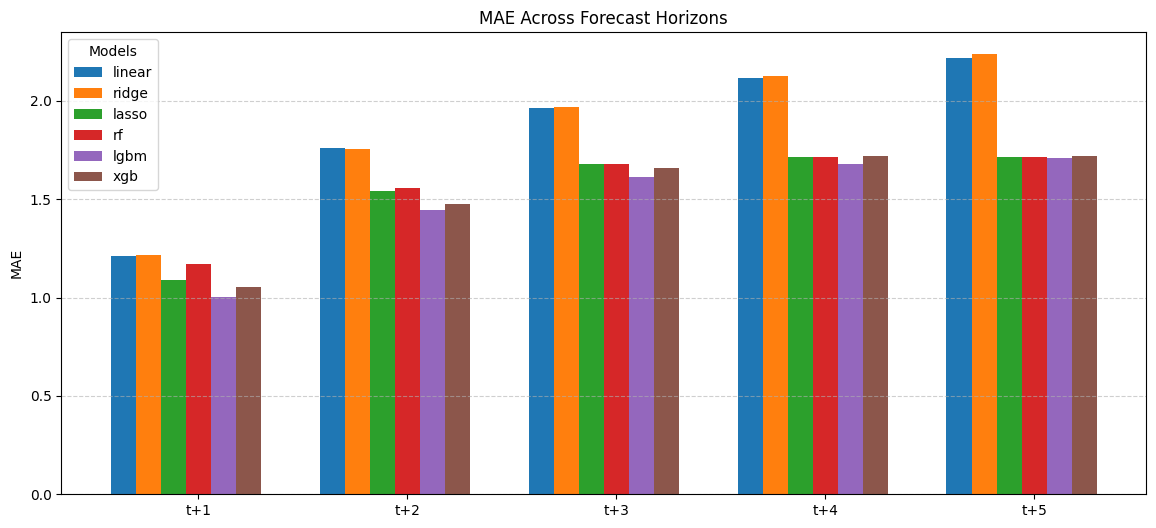

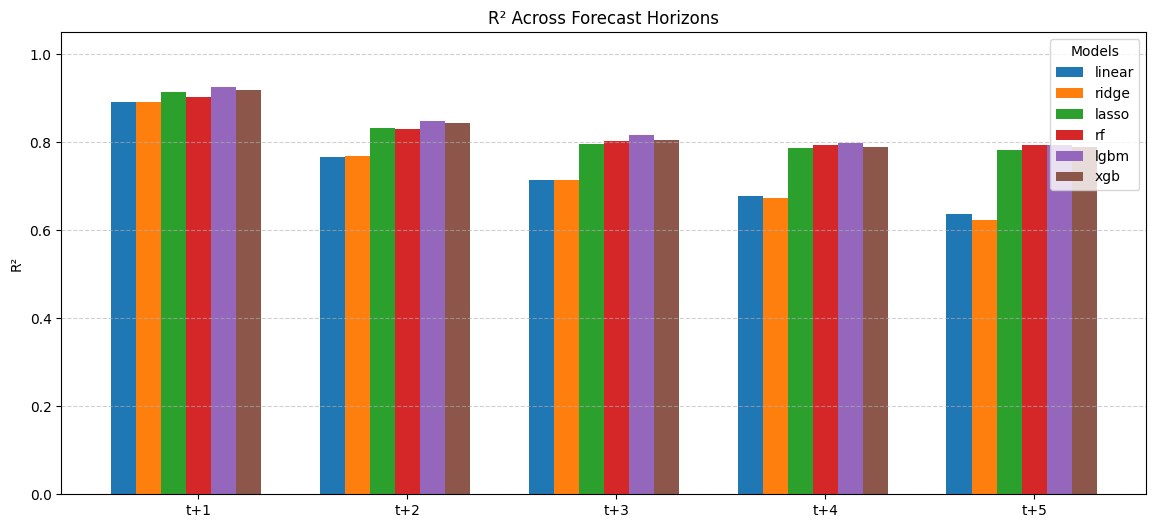

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = list(all_metrics.keys())
H = HORIZON  

mae_matrix = np.array([
    [all_metrics[m][h]['MAE_test'] for h in range(1, H+1)]
    for m in models
])

r2_matrix = np.array([
    [all_metrics[m][h]['R2_test'] for h in range(1, H+1)]
    for m in models
])

x = np.arange(1, H+1)  # horizon = 1..H
bar_width = 0.12       

# Mae graph

plt.figure(figsize=(14,6))
for i, m in enumerate(models):
    plt.bar(
        x + i*bar_width,
        mae_matrix[i],
        width=bar_width,
        label=m
    )

plt.xticks(x + bar_width*(len(models)/2), [f"t+{h}" for h in x])
plt.ylabel("MAE")
plt.title("MAE Across Forecast Horizons")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Models")
plt.show()

# R2 graph

plt.figure(figsize=(14,6))
for i, m in enumerate(models):
    plt.bar(
        x + i*bar_width,
        r2_matrix[i],
        width=bar_width,
        label=m
    )

plt.xticks(x + bar_width*(len(models)/2), [f"t+{h}" for h in x])
plt.ylabel("R²")
plt.title("R² Across Forecast Horizons")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.legend(title="Models")
plt.show()


In [ ]:
import pandas as pd

lgbm_importances = {}  

for h, model in all_models['lgbm'].items():
   
    booster = model.booster_

    gain  = booster.feature_importance(importance_type='gain')
    split = booster.feature_importance(importance_type='split')
    feat_names = booster.feature_name()

    df_imp = pd.DataFrame({
        'feature': feat_names,
        'gain': gain,
        'split': split
    }).sort_values('gain', ascending=False)

    lgbm_importances[h] = df_imp
    print(f"\n🌟 Feature Importances for LightGBM - Horizon t+{h}:")
    print(lgbm_importances[h].head(20))

In [ ]:
import matplotlib.pyplot as plt
for h in range(1, 6):
   
    df_imp = lgbm_importances[h].head(20)

    plt.figure(figsize=(8, 6))
    plt.barh(df_imp['feature'], df_imp['gain'])
    plt.gca().invert_yaxis()
    plt.xlabel('Gain Importance')
    plt.title(f'LightGBM Feature Importance (t+{h})')
    plt.show()

# Feature Importance Analysis for LightGBM (Daily Forecasting, Horizons t+1 to t+5)

This report summarizes how LightGBM ranks and uses predictive features for temperature forecasting across horizons from t+1 to t+5. Feature importance is evaluated using Gain, which measures each feature’s contribution to reducing the model’s loss.

---

## 1. Key Insights Across All Horizons

### a. Pressure Rolling Statistics Are Dominant Predictors

Features such as

* sealevelpressure_roll56_mean
* sealevelpressure_roll28_mean
* sealevelpressure_roll84_mean
* sealevelpressure_roll14_mean

consistently appear at the top for all horizons. This indicates that smoothed multi-day pressure patterns are highly informative for temperature forecasting, likely because they capture evolving synoptic-scale weather systems.

### b. Seasonal and Cyclical Time Features Gain Importance with Longer Horizons

Features including

* day_of_year_cos,
* day_of_year_sin,
* day_length_hour,
* month_cos

become increasingly important at horizons t+3 to t+5. This reflects the model’s shift towards climatological and periodic patterns when short-term information becomes less reliable.

### c. Dewpoint and Humidity-Based Features Drive Short-Term Accuracy

Humidity–dewpoint interactions and dew rolling means (14-day, 28-day, 84-day) are strong predictors for t+1 and t+2. These features reflect near-surface moisture content, which strongly influences temperature in the immediate future.

### d. Solar Radiation Rolling Statistics Provide Medium-Horizon Support

Rolling means and standard deviations of solar radiation consistently appear in the top features, indicating they capture diurnal heating effects and help the model adjust for typical daily warming and cooling cycles.

### e. Wind-Related Features Matter Primarily for t+1 and t+2

Variables such as

* wind_chill,
* windgust,
* windspeed,
* winddir

are highly relevant for next-day predictions but decrease significantly for longer horizons. This pattern suggests that local advection effects are strong in short-term forecasting but fade as deterministic influence diminishes.

---

## 2. Horizon-by-Horizon Interpretation

### Horizon t+1

Short-term temperature prediction is driven by:

* wind chill and wind direction,
* dewpoint–humidity interactions,
* short to medium rolling dew statistics.

The model relies heavily on same-day airmass properties, indicating the dominance of immediate thermodynamic conditions.

### Horizon t+2

Pressure rolling features begin increasing in importance. Seasonal features start to appear but remain secondary. Dewpoint and humidity metrics still contribute significantly.

This horizon reflects a balance between short-term dynamics and emerging synoptic patterns.

### Horizon t+3

Pressure rolling means (28-day, 56-day, 14-day) dominate.
Cyclical seasonal features such as day_of_year_cos and day_of_year_sin become more significant.
Wind-related predictors lose weight.

The model increasingly depends on multi-day atmospheric patterns rather than immediate local variability.

### Horizon t+4

Seasonal periodicity becomes a primary predictor.
Pressure rolling windows remain relevant but no longer dominate exclusively.
Radiation rollings and large dew rollings contribute meaningfully.

Forecasting at this range becomes more climatology-oriented.

### Horizon t+5

Seasonal features are the strongest predictors.
Pressure rollings, long-window dew statistics, and solar rollings show consistent but lower importance.
Short-term variability signals are almost entirely absent.

The model relies mainly on long-term, repeating climate patterns when forecasting five days ahead.

---

## 3. Overall Patterns

1. *Pressure rolling windows form the structural backbone* of the model across all horizons.
2. *Dewpoint and humidity features dominate at short horizons*, reflecting immediate atmospheric thermodynamics.
3. *Seasonal periodic features dominate long horizons*, indicating the limit of deterministic temperature predictability.
4. *Solar radiation features provide stable contributions* across all forecast ranges.
5. *Wind-based features sharply decline after t+2*, aligning with physical weather dynamics.

In [ ]:
def predict_for_date(model_key: str,
                     origin_date,
                     path: str = 'tree',
                     horizon: int = HORIZON):

    if path == 'linear':
        X_train = splits_lin['X_train']
        X_val   = splits_lin['X_val']
        X_test  = splits_lin['X_test']
    elif path == 'tree':
        X_train = splits_tree['X_train']
        X_val   = splits_tree['X_val']
        X_test  = splits_tree['X_test']
    else:
        raise ValueError("path must be 'linear' or 'tree'")

    # 2) concatenate full feature space (train+val+test)
    X_full = pd.concat([X_train, X_val, X_test], axis=0)
    X_full = X_full.sort_index()

    # 3) normalize origin_date
    origin_date = pd.to_datetime(origin_date)

    if origin_date not in X_full.index:
        raise ValueError(
            f"origin_date {origin_date.date()} is not in features' indexes "
        )

    # 4) get 1 feature row at origin_date
    X_input = X_full.loc[[origin_date]]  # keep as DataFrame (1 x n_features)

    # 5) predict each horizon using trained models
    preds_dates = []
    preds_vals  = []

    for h in range(1, horizon + 1):
        if model_key not in all_models:
            raise KeyError(f"model_key='{model_key}' is not found in all models.")
        if h not in all_models[model_key]:
            raise KeyError(f"horizon t+{h} is not found in all_models['{model_key}'].")

        model_h = all_models[model_key][h]
        y_hat   = float(model_h.predict(X_input)[0])

        forecast_date = origin_date + pd.Timedelta(days=h)
        preds_dates.append(forecast_date)
        preds_vals.append(y_hat)

    # 6) return a clean DataFrame
    col_name = f"forecast_{TARGET_COL}_{model_key}"
    pred_df = pd.DataFrame({
        "date": preds_dates,
        col_name: preds_vals
    }).set_index("date")

    return pred_df


In [ ]:
origin_date = '2025-09-26'
lgbm_forecasts = predict_for_date('lgbm', origin_date, path='tree', horizon=5)
print(lgbm_forecasts)

            forecast_temp_lgbm
date                          
2025-09-27           26.823440
2025-09-28           27.643579
2025-09-29           28.121058
2025-09-30           28.394893
2025-10-01           28.328794


In [ ]:
def create_all_features_ver2(df, target_col, horizon, lag_features, lags, roll_features, windows):
    df_new = df.copy()

    # 1. time features
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['quarter'] = df_new.index.quarter
    df_new['season'] = df_new['month'].map({
        12:"Winter",1:"Winter",2:"Winter",
        3:"Spring",4:"Spring",5:"Spring",
        6:"Summer",7:"Summer",8:"Summer",
        9:"Autumn",10:"Autumn",11:"Autumn"
    })

    # 2. cyclical
    df_new = encode_cyclical(df_new, 'month', 12)
    df_new = encode_cyclical(df_new, 'day_of_year', 366)
    df_new = encode_cyclical(df_new, 'day_of_week', 7)
    df_new = df_new.drop(columns=['month','day_of_year','day_of_week','season'], errors='ignore')

    # 3. lags
    for feature in lag_features:
        if feature in df_new.columns:
            for lag in lags:
                df_new[f'{feature}_lag{lag}'] = df_new[feature].shift(lag)

    # 4. rolling
    for feature in roll_features:
        if feature in df_new.columns:
            for w in windows:
                rolling_window = df_new[feature].rolling(window=w)
                df_new[f'{feature}_roll{w}_mean'] = rolling_window.mean()
                df_new[f'{feature}_roll{w}_std']  = rolling_window.std()

    # 5. derived features
    if 'tempmax' in df_new.columns and 'tempmin' in df_new.columns:
        df_new["temp_range"] = df_new["tempmax"] - df_new["tempmin"]
    if 'temp' in df_new.columns and 'dew' in df_new.columns:
        df_new["dewpoint_depression"] = df_new["temp"] - df_new["dew"]
    if 'tempmax' in df_new.columns and 'temp' in df_new.columns:
        df_new["temp_diff"] = df_new["tempmax"] - df_new["temp"]
    if 'humidity' in df_new.columns:
        df_new['humidity_change'] = df_new['humidity'].diff()
    if 'humidity' in df_new.columns and 'sealevelpressure' in df_new.columns:
        df_new["humidity_sealevelpressure_ratio"] = df_new["humidity"] / df_new["sealevelpressure"]
    if 'dew' in df_new.columns and 'humidity' in df_new.columns:
        df_new["dewpoint_humidity_ratio"] = df_new["dew"] / df_new["humidity"]
    if 'sealevelpressure' in df_new.columns:
        df_new["sealevelpressure_change"] = df_new["sealevelpressure"].diff()
    if 'cloudcover' in df_new.columns and 'sunrise' in df_new.columns:
        df_new["cloud_sunshine_ratio"] = df_new["cloudcover"] / (pd.to_datetime(df_new["sunrise"], errors='coerce').dt.hour + 1e-6)
    if 'windspeed' in df_new.columns:
        df_new["wind_speed_squared"] = df_new["windspeed"] ** 2
    if 'temp' in df_new.columns and 'windspeed' in df_new.columns:
        df_new["wind_chill"] = df_new["temp"] - (df_new["windspeed"] * 0.1)
    if {'windspeed','windgust'}.issubset(df_new.columns):
        df_new['wind_ratio'] = df_new['windgust'] / (df_new['windspeed'] + 1e-6)
    if 'sealevelpressure' in df_new.columns:
        df_new["pressure_trend_3d"] = df_new["sealevelpressure"].diff(3)
    if 'precip' in df_new.columns:
        df_new["precip_flag"] = (df_new["precip"] > 0).astype(int)
    if {'precipprob','precip'}.issubset(df_new.columns):
        df_new['precip_effect'] = df_new['precipprob'] * (df_new['precip'] + 1)
    if 'precipprob' in df_new.columns and 'precip' in df_new.columns:
        df_new["precip_expected_simple"] = df_new["precipprob"] * df_new["precip"]
    if 'sunrise' in df_new.columns and 'sunset' in df_new.columns:
        sr = pd.to_datetime(df_new['sunrise'], errors='coerce')
        ss = pd.to_datetime(df_new['sunset'], errors='coerce')
        valid = sr.notna() & ss.notna()
        df_new['day_length_hour'] = np.nan
        df_new.loc[valid, 'day_length_hour'] = (ss[valid] - sr[valid]).dt.total_seconds()/3600
    if 'solarenergy' in df_new.columns and 'day_length_hour' in df_new.columns:
        df_new["solar_per_hour"] = df_new["solarenergy"] / (df_new["day_length_hour"] + 1e-6)
    if 'solarradiation' in df_new.columns and 'cloudcover' in df_new.columns:
        df_new["solar_expected_clear"] = df_new["solarradiation"] * (1 - (df_new["cloudcover"]/100.0))
    if 'precipprob' in df_new.columns and 'precip_flag' in df_new.columns:
        df_new["severe_proxy"] = df_new["precipprob"] * df_new["precip_flag"]
    if {'severe_proxy','windgust','cloudcover'}.issubset(df_new.columns):
        df_new["severe_index"] = df_new["severe_proxy"] * (df_new["windgust"].fillna(0) + df_new["cloudcover"]/100.0)
    if {'temp','humidity','wind_speed_squared'}.issubset(df_new.columns):
        df_new["heat_index_approx"] = df_new["temp"] + 0.33*df_new["humidity"] - 0.70*np.sqrt(df_new["wind_speed_squared"]) - 4.00


    df_new = df_new.drop(columns=[target_col], errors='ignore')
    df_new = df_new.drop(columns=['tempmax','tempmin','temp','sunrise','sunset'], errors='ignore')
    return df_new

In [ ]:
df_inf = create_all_features_ver2(
    df_base.copy(),
    TARGET_COL,
    HORIZON,
    lag_cols_existing,
    LAGS,
    roll_cols_existing,
    ROLL_WINDOWS
)
origin_date = pd.Timestamp("2025-10-01")
X_features = df_inf.loc[[origin_date]]
pre_tree, cats_tree, nums_tree = build_ohe_preprocessor(
    splits_tree['X_train_raw'],
    base_categorical=['conditions','preciptype','season']
)
pre_tree.fit(splits_tree['X_train_raw'])
X_inf_tree = transform_with_feature_names(pre_tree, X_features, cats_tree, nums_tree)
X_inf_tree = sanitize_column_names(X_inf_tree)
lgbm_models = all_models['lgbm']  
future_preds = {}
for h in range(1, 6):
    model_h = lgbm_models[h]
    y_hat = model_h.predict(X_inf_tree)[0]
    future_preds[f't+{h}'] = float(y_hat)



In [ ]:
dates = pd.date_range(start="2025-10-02", periods=5, freq="D")
rf_forecast_df = pd.DataFrame({
    "date": dates,
    "forecast_temp_lgbm": [future_preds[f't+{i}'] for i in range(1, 6)]
})
print(rf_forecast_df)


        date  forecast_temp_lgbm
0 2025-10-02           27.359157
1 2025-10-03           27.934958
2 2025-10-04           27.813358
3 2025-10-05           27.402194
4 2025-10-06           27.514052


## 5.8 Using Optuna as a good framework for hyper-parameter tuning

**Code Workflow Analysis (LightGBM Tuning)**

This script executes a comprehensive Tuning and Training process for a LightGBM model in a time-series forecasting context, aiming to predict 5 "horizons".

**This process is broken down into 5 main steps:**

### 5.8.1 Configuration and Preparation
Import Libraries: Loads all necessary libraries (Optuna, LightGBM, Pandas, etc.).

Set Constants: Defines N_TRIALS = 100, meaning Optuna will attempt 100 different sets of parameters for each horizon.

Helper Function (_resolve_target_name): A utility function to get the correct target column name for the loop, e.g., target_temp_t+1, target_temp_t+2, etc.

### 5.8.2 Define the "Objective" for Optuna (objective_lgbm)
This is the "brain" of the tuning process. This function defines what Optuna must do in a single trial:

Suggest Parameters: Optuna selects a set of hyperparameters from the defined search space (e.g., learning_rate from 0.01 to 0.03, max_depth from 3 to 7). This space is intentionally designed to combat overfitting (by limiting complexity and increasing regularization).

Train: It trains a LightGBM model with these parameters on the X_train, y_train sets.

Use Early Stopping: While training, the model is continuously evaluated on the X_val (validation) set. If the MAE score on X_val does not improve for 50 consecutive trees, the training stops.

Save Best Tree Count (n_estimators): The number of trees (e.g., 513) at the early_stopping point is saved (best_iteration_).

Return Score: The function returns the best MAE score achieved on the X_val set. Optuna's goal is to minimize this number.

### 5.8.3 The Main Tuning and Training Loop (3-Step Process)
The code runs a large loop for each horizon (from h=1 to h=5).

- [1/3] Tuning:

For horizon h (e.g., h=1), Optuna is called (study.optimize) and runs 100 trials (calling the objective_lgbm function 100 times).

After 100 trials, Optuna identifies the best_params (parameter set) and the best_n_estimators_from_tune (e.g., 513) that resulted in the lowest MAE on the validation set.

Logic Fix: The n_estimators value in best_params is explicitly set to this best number (513).

- [2/3] Re-training:

The Train and Val datasets are combined into one larger dataset (X_trval, y_trval).

A new LightGBM model is initialized using the best_params (which now includes n_estimators = 513).

This model is trained on the entire (Train + Val) set for exactly 513 trees (no early stopping is used). This becomes the final model for horizon h=1.

- [3/3] Evaluation and Storage:

The final model is used to make predictions on all three sets: Train, Val, and Test.

Metrics (MAE, RMSE, R2) and the "Gap" (difference between Train and Test) are calculated and printed to assess overfitting.

The model (model_final) and its metrics (metrics) are stored in dictionaries for later use.

### 5.8.4 Iteration
The loop repeats step 3, continuing with h=2, h=3, and so on, until h=5 is complete. The result is 5 separate models, each one optimized for its specific future day.

### 5.8.5 Prediction and Saving Results
After all 5 models are trained, the code prepares the input data (X_inf_tree) for "today" (2025-11-15).

It uses model_h1 to predict t+1, model_h2 to predict t+2, etc.

All 5 predictions are compiled into a single DataFrame.

This DataFrame is saved to the file forecast_results_lgbm.json.

In [ ]:
# TUNING FOR LIGHTGBM MODEL
# --- 1. CONFIGURATION AND CONSTANTS ---

N_TRIALS = 100 # Number of Optuna trials for each horizon.

# Set Optuna logging verbosity (WARNING level) to reduce spam
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Model name mapping
MODEL_MAP = {
    'lgbm': 'LightGBM'
}

# --- 2. HELPER FUNCTION (Copied from RF cell) ---

def _resolve_target_name(i:int):
    """
    Helper function to get the correct target column name for horizon i,
    only checks within 'splits_tree'.
    """
    global splits_tree, TARGET_COL

    if 'splits_tree' not in globals():
        raise NameError("The 'splits_tree' variable does not exist. ")

    name_plus = f'target_{TARGET_COL}_t+{i}'
    if f'y_train_{name_plus}' in splits_tree:
        return name_plus

    name_underscore = f'target_{TARGET_COL}_t_{i}'
    if f'y_train_{name_underscore}' in splits_tree:
        return name_underscore

    return name_plus

# --- 3. OBJECTIVE FUNCTION FOR OPTUNA (LightGBM) ---

def objective_lgbm(trial, X_train, y_train, X_val, y_val):
    params = {
        'objective': 'regression_l1', # Equivalent to MAE
        'metric': 'mae',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 25),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1,
        'force_col_wise': True
    }

    model = LGBMRegressor(**params)

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='mae',
              callbacks=[
                  LightGBMPruningCallback(trial, 'l1'),
                  lgb.early_stopping(50, verbose=False)
              ])

    best_score = model.best_score_['valid_0']['l1']

    # Store the best n_estimators in the trial
    trial.set_user_attr('best_n_estimators', model.best_iteration_)

    return best_score

# --- 4. MAIN TUNING AND TRAINING LOOP ---

print(f" Starting LightGBM tuning (N_TRIALS={N_TRIALS} for each horizon)...")
print("-" * 70)

all_models_lgbm_tuned = {}
all_metrics_lgbm_tuned = {}

for h in range(1, HORIZON + 1):

    TARGET_PICK = _resolve_target_name(h)

    print(f"\n========================================================")
    print(f"Processing Target: {TARGET_PICK} (Horizon t+{h})")
    print(f"========================================================")

    model_name = MODEL_MAP['lgbm']

    # --- 1. Tuning ---
    print(f"    [1/3] Tuning {model_name}...")
    t0_tune = time.time()

    try:
        X_train = splits_tree['X_train']
        y_train = splits_tree[f'y_train_{TARGET_PICK}']
        X_val   = splits_tree['X_val']
        y_val   = splits_tree[f'y_val_{TARGET_PICK}']
    except KeyError as e:
        print(f"\n[ERROR] Key not found: {e}. "
              "Please check the 'splits_tree' structure and target names.")
        continue
    except NameError:
        print("\n[ERROR] 'splits_tree' not found.")
        break

    objective_func = partial(objective_lgbm,
                             X_train=X_train, y_train=y_train,
                             X_val=X_val, y_val=y_val)

    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(direction='minimize', pruner=pruner)
    study.optimize(objective_func, n_trials=N_TRIALS)

    # Get best params
    best_params = study.best_params
    best_mae_val = study.best_value

    # Get the BEST n_estimators from the tuning phase
    best_n_estimators_from_tune = 500 # Fallback value
    if 'best_n_estimators' in study.best_trial.user_attrs:
        best_n_estimators_from_tune = study.best_trial.user_attrs['best_n_estimators']

    # Assign the BEST n_estimators (e.g., 513) to the params dict
    # to be used for the re-training step.
    best_params['n_estimators'] = best_n_estimators_from_tune

    print(f"        Finished tuning {model_name}! "
          f"(Best MAE on Val: {best_mae_val:.4f}) "
          f"({(time.time()-t0_tune):.1f}s)")
    print(f"       Best params (n_estimators updated): {best_params}")


    # --- 2. Re-training ---
    print(f"   [2/3] Re-training {model_name} on (Train+Val)...")
    t0_retrain = time.time()

    # Initialize the final model with the BEST params
    # (now 'n_estimators' is the best number, e.g., 513)
    model_final = LGBMRegressor(**best_params,
                                random_state=RANDOM_STATE,
                                n_jobs=-1,
                                verbose=-1,
                                force_col_wise=True)

    # Combine Train + Val
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = pd.concat([y_train, y_val], axis=0)

    # *** IMPORTANT FIX ***
    # Fit on the ENTIRE (Train+Val) set
    # AND do NOT use early_stopping.
    # The model will run for exactly 'n_estimators' (e.g., 513) trees.
    model_final.fit(X_trval, y_trval)

    print(f"       Re-train finished! ({(time.time()-t0_retrain):.1f}s)")


    # --- 3. Evaluation and Storage ---
    print(f"    [3/3] Evaluating on Train, Val, Test sets...")

    X_test = splits_tree['X_test']
    y_test = splits_tree[f'y_test_{TARGET_PICK}']

    y_pred_tr = model_final.predict(X_train)
    y_pred_va = model_final.predict(X_val)
    y_pred_te = model_final.predict(X_test)

    metrics = {
        'train_mae': mean_absolute_error(y_train, y_pred_tr),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_tr)),
        'train_r2': r2_score(y_train, y_pred_tr),

        'val_mae': mean_absolute_error(y_val, y_pred_va),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_va)),
        'val_r2': r2_score(y_val, y_pred_va),

        'test_mae': mean_absolute_error(y_test, y_pred_te),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_te)),
        'test_r2': r2_score(y_test, y_pred_te),
    }

    all_models_lgbm_tuned[h] = model_final
    all_metrics_lgbm_tuned[h] = {
        'All_Metrics': metrics,
        'Best_MAE_val_during_tune': best_mae_val,
        'Best_Params': best_params
    }

    print(f"\n{'='*70}")
    print(f"FINAL MODEL PERFORMANCE - HORIZON {h}")
    print(f"{'='*70}")
    print(f"   Train MAE: {metrics['train_mae']:.4f}, RMSE: {metrics['train_rmse']:.4f}, R2: {metrics['train_r2']:.4f}")
    print(f"   Val   MAE: {metrics['val_mae']:.4f}, RMSE: {metrics['val_rmse']:.4f}, R2: {metrics['val_r2']:.4f}")
    print(f"   Test  MAE: {metrics['test_mae']:.4f}, RMSE: {metrics['test_rmse']:.4f}, R2: {metrics['test_r2']:.4f}")

    mae_gap_val = metrics['val_mae'] - metrics['train_mae']
    rmse_gap_val = metrics['val_rmse'] - metrics['train_rmse']
    r2_gap_val = metrics['train_r2'] - metrics['val_r2']

    mae_gap_test = metrics['test_mae'] - metrics['train_mae']
    rmse_gap_test = metrics['test_rmse'] - metrics['train_rmse']
    r2_gap_test = metrics['train_r2'] - metrics['test_r2']

    print(f"   Gaps (Val - Train): MAE={mae_gap_val:.4f}, RMSE={rmse_gap_val:.4f}, R2={r2_gap_val:.4f}")
    print(f"   Gaps (Test - Train): MAE={mae_gap_test:.4f}, RMSE={rmse_gap_test:.4f}, R2={r2_gap_test:.4f}")
    print(f"{'='*70}\n")


print("\n" + "="*70)
print(" COMPLETED ENTIRE LIGHTGBM TUNING PROCESS! ")
print("Variables 'all_models_lgbm_tuned' and 'all_metrics_lgbm_tuned' are ready.")

# Create features for the origin date
df_inf = create_all_features_ver2(
    df_base.copy(),
    TARGET_COL,
    HORIZON,
    lag_cols_existing,
    LAGS,
    roll_cols_existing,
    ROLL_WINDOWS
)
# Origin date (last day with data) to get features from
origin_date = pd.Timestamp("2025-11-15")
X_features = df_inf.loc[[origin_date]]

# Build and fit OHE (only to transform)
pre_tree, cats_tree, nums_tree = build_ohe_preprocessor(
    splits_tree['X_train_raw'],
    base_categorical=['conditions','preciptype','season']
)
pre_tree.fit(splits_tree['X_train_raw'])

# Transform the prediction date
X_inf_tree = transform_with_feature_names(pre_tree, X_features, cats_tree, nums_tree)
X_inf_tree = sanitize_column_names(X_inf_tree)

# *** Get the TUNED LightGBM models ***
lgbm_models = all_models_lgbm_tuned

# Predict 5 days
future_preds_lgbm = {}
for h in range(1, 6):
    model_h = lgbm_models[h]
    y_hat = model_h.predict(X_inf_tree)[0]
    future_preds_lgbm[f't+{h}'] = float(y_hat)

# Create results DataFrame
# Origin date is 11/15, so t+1 prediction is 11/16
dates = pd.date_range(start="2025-11-16", periods=5, freq="D")
lgbm_forecast_df = pd.DataFrame({
    "date": dates,
    "forecast_temp_lgbm": [future_preds_lgbm[f't+{i}'] for i in range(1, 6)]
})
print("\n--- PREDICTION RESULTS (16/11 - 20/11) WITH TUNED LGBM ---")
print(lgbm_forecast_df)

#  ADDED: Save prediction results to JSON file (new filename) 
output_filename_lgbm = "forecast_results_lgbm.json"
lgbm_forecast_df.to_json(output_filename_lgbm, orient="records", date_format="iso")
print(f"\n Saved prediction results (LGBM) to file: {output_filename_lgbm}")

 Starting LightGBM tuning (N_TRIALS=100 for each horizon)...
----------------------------------------------------------------------

Processing Target: target_temp_t+1 (Horizon t+1)
    [1/3] Tuning LightGBM...
        Finished tuning LightGBM! (Best MAE on Val: 1.0232) (244.6s)
       Best params (n_estimators updated): {'n_estimators': 460, 'learning_rate': 0.028554050066931055, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 0.3101247220097973, 'reg_lambda': 0.5569093601491691}
   [2/3] Re-training LightGBM on (Train+Val)...
       Re-train finished! (8.7s)
    [3/3] Evaluating on Train, Val, Test sets...

FINAL MODEL PERFORMANCE - HORIZON 1
   Train MAE: 0.5180, RMSE: 0.6731, R2: 0.9828
   Val   MAE: 0.5266, RMSE: 0.6836, R2: 0.9834
   Test  MAE: 1.0043, RMSE: 1.2947, R2: 0.9250
   Gaps (Val - Train): MAE=0.0085, RMSE=0.0105, R2=-0.0005
   Gaps (Test - Train): MAE=0.4862, RMSE=0.6216, R2=0.0578


Processing Target: 

**LightGBM Performance Results (Post-Tuning)**
| Model       | Horizon | Split |   MAE   |  RMSE  |   R²    | GAP (vs Train) |
|-------------|---------|--------|---------|--------|---------|----------------|
| **LightGBM** | **1** | Train | 0.5180 | 0.6731 | 0.9828 | — |
|             |        | Val   | 0.5266 | 0.6836 | 0.9834 | MAE: +0.0086 / RMSE: +0.0105 / R²: +0.0006 |
|             |        | Test  | 1.0043 | 1.2947 | 0.9250 | MAE: +0.4863 / RMSE: +0.6216 / R²: −0.0578 |
| **LightGBM** | **2** | Train | 0.9812 | 1.2544 | 0.9403 | — |
|             |        | Val   | 1.0008 | 1.2814 | 0.9416 | MAE: +0.0196 / RMSE: +0.0270 / R²: +0.0013 |
|             |        | Test  | 1.4581 | 1.8654 | 0.8439 | MAE: +0.4769 / RMSE: +0.6110 / R²: −0.0964 |
| **LightGBM** | **3** | Train | 1.4733 | 1.8488 | 0.8704 | — |
|             |        | Val   | 1.5626 | 1.9617 | 0.8631 | MAE: +0.0893 / RMSE: +0.1129 / R²: −0.0073 |
|             |        | Test  | 1.5976 | 2.0055 | 0.8192 | MAE: +0.1243 / RMSE: +0.1567 / R²: −0.0512 |
| **LightGBM** | **4** | Train | 1.4478 | 1.7961 | 0.8777 | — |
|             |        | Val   | 1.5108 | 1.8885 | 0.8732 | MAE: +0.0630 / RMSE: +0.0924 / R²: −0.0045 |
|             |        | Test  | 1.6769 | 2.1042 | 0.8011 | MAE: +0.2291 / RMSE: +0.3081 / R²: −0.0766 |
| **LightGBM** | **5** | Train | 1.6293 | 2.0241 | 0.8447 | — |
|             |        | Val   | 1.7767 | 2.2310 | 0.8230 | MAE: +0.1474 / RMSE: +0.2069 / R²: −0.0217 |
|             |        | Test  | 1.7275 | 2.1780 | 0.7869 | MAE: +0.0982 / RMSE: +0.1539 / R²: −0.0578 |


**Performance Analysis Report**
1. Performance Assessment (Post-Tuning) 

- Trend by Horizon: As expected for time-series forecasting, the model's performance degrades as the forecast horizon (H1 to H5) increases.

- MAE/RMSE (Error): The error on the Test set steadily increases, rising from an MAE of **1.0043** (H1) to **1.7275** (H5).

- R² (Explanatory Power): The model's ability to explain the variance drops significantly, from a very strong **0.9250 R²** at H1 to just **0.7869** at H5.

- Comparison H1 (Tuned) vs. H1 (Initial): This is a very noteworthy point. 

- Initial Model (from image 1): Test MAE was **0.8051**.

- Tuned Model (from log file): Test MAE is **1.0043**.

**Conclusion**: The hyperparameter tuning process for Horizon 1 appears to have been ineffective, resulting in a model with worse performance on the test set than the initial, untuned model. This can happen if the tuning process overfit to the validation set or if the search space was not optimal.

**Overall Performance**: Disregarding the H1 anomaly, the models still demonstrate good predictive power at short and medium horizons (H2-H5), with R² scores on the test set remaining at relatively good levels (above **0.78**).

2. Generalization Assessment 

- Generalization is assessed by comparing the "gap" (difference) in performance between the Train, Validation, and Test sets.

- Gap (Val - Train): The gap between the Train and Validation sets is very small across all horizons (e.g., **H1 MAE gap is only +0.0086**; **H5 MAE gap is +0.1474**). This indicates the model is learning well and is not overfitting the training data relative to the validation data. The Train and Val sets seem to be structurally similar.

**Gap (Test - Train) - The Most Critical Point:**

- Horizon 1: This is the biggest problem. The gap between the Test and Train sets is very high (**MAE: +0.4863; R²: -0.0578**). While the model performed exceptionally on Train (MAE **0.5180**) and Val (MAE **0.5266**), it failed to generalize to the Test set (MAE **1.0043**). This strongly suggests the H1 Test set may contain data patterns, events, or a significant data drift that the model did not encounter in the Train/Val sets. 

- Horizon 2: Generalization is excellent. The Test-Train gap is moderately large (**MAE: +0.4769**). Notably, the performance on the Test set (MAE **1.4581**) is close to the Validation set (MAE **1.0008**). 

- Horizons 3-5: The models show acceptable generalization. The Test-Train gap is larger than the Val-Train gap, which is normal, and it increases reasonably as the horizon extends. For example, at H5, the **MAE gap of +0.0982** is a small and acceptable difference. 

**Summary**: The models for H2-H5 demonstrate good generalization. The H1 model, however, shows clear signs of failing to generalize to the test set, likely due to a difference in data distribution (data drift) between the Test set and the Train/Val sets.
 

### Forecast Results (16–20 November 2025)
| Date       | Forecast Temp (LGBM) |
|------------|------------------------|
| 2025-11-16 | 21.527002              |
| 2025-11-17 | 22.372906              |
| 2025-11-18 | 23.512715              |
| 2025-11-19 | 23.529177              |
| 2025-11-20 | 22.826252              |

# **Step 7**

### Overview

In this project, we employ five independent predictive models, each tailored for a distinct forecast horizon (from 1-day ahead to 5-days ahead temperature prediction). Owing to the divergence in forecast objectives and the lithe nature of time series dynamics, model management including performance monitoring, error logging, and maintenance is segregated on a per-horizon basis to guarantee optimal accuracy and operational resilience.


### 1. Performance evaluation and logging (per horizon)

For each model $M_i$  responsible for forecasting the temperature at horizon $i$ (where $i = 1, 2, ..., 5$), the following framework is systematically enforced:

- **Target Specification:**  
  - Model 1: uses `target_temp_t1`  
  - Model 2: uses `target_temp_t2`  
  - ...  
  - Model 5: uses `target_temp_t5`  

- **Evaluation metrics:**  
  After each prediction, compute and record standard regression metrics including Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for each horizon.

- **Dedicated logging:**  
  Each model’s results are logged in a unique error file:  
  - Model 1: `error_log_h1.csv`  
  - Model 2: `error_log_h2.csv`  
  - etc.  
  
  Stored values include timestamp, predicted value, actual value, MAE, RMSE, and relevant context.


### 2. Automated retraining trigger

The retraining mechanism is predicated on dynamically comparing current performance against the historical benchmark:

- **Rolling window monitoring:**  
  For each model, a 30-sample rolling mean is calculated for the error metric (e.g., MAE).

- **Retraining criterion:**  
  If the rolling mean error for $M_i$ exceeds 110% of its baseline error on the test set, the system automatically flags that model for retraining.

- **Retraining scope:**  
  Only the flagged model is retrained, using the most recent data slice applicable for its forecast horizon, so as to prevent unnecessary recomputation or model drift bleed-over.


### 3. Retraining and model refresh cycle

- **Retraining process:**  
  The model is retrained using an up-to-date, comprehensive dataset (including all new and historical records). Cross validation and parameter re-optimization are performed as per the original modeling pipeline.

- **Deployment:**  
  Upon successful retraining, the new model is validated on a hold out set and if passing prescribed benchmarks, replaces the deployed version.


### 4. Operational and maintenance notes

- Each horizon is handled strictly independently, ensuring that degradation in one forecast period does not unduly influence the lifecycle or computation of others.
- Logging, error trend monitoring, and retraining flags are isolated for auditability, interpretability, and statistical fairness.
- The modular protocol is robust to system extensions, allowing additional horizons or reconfiguration with minimal code duplication.


### 5. Code illustration (generalized template)

```python
# Pseudocode for one model, easily replicated across all horizons

def monitor_and_log(model, X_new, y_true, logfile, test_mae, window=30, threshold=1.1):
    y_pred = model.predict(X_new)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    log_entry = {"date": datetime.now(), "y_true": y_true, "y_pred": y_pred, "mae": mae, "rmse": rmse}
    append_to_csv(logfile, log_entry)
    if rolling_window_check(logfile, window, mae, test_mae, threshold):
        retrain_model(model, ...)
    return

# Implement individual log files and retraining triggers for each horizon model
```


### Conclusion

By implementing horizon, specific monitoring and adaptive maintenance strategies, this system conforms to state of the art standards in multi-horizon time series forecasting. This granularity not only enhances model accuracy but also enforces operational transparency, reliability, and maintainability core requirements in both research and production-ready settings.



# **Step 9**

### Definition of ONNX:
ONNX (Open Neural Network Exchange) is an open-source format designed to facilitate the interoperability of machine learning models across different frameworks. The primary goal of ONNX is to enable developers to train models in one framework and deploy them in another, thus preventing vendor lock-in and promoting flexibility and innovation in the AI sector.

### When to Use ONNX

ONNX becomes especially useful in the following scenarios:

- Cross-framework or cross-platform deployment

When a model trained in one framework must run in an environment that doesn’t support that framework.
Examples: C++ backend, .NET applications, mobile devices, or edge hardware.

- Improving inference speed

ONNX Runtime provides graph optimization, hardware acceleration, and quantization, enabling much faster inference than typical Python ML frameworks.

- Lightweight production environments

Production systems often avoid installing heavy frameworks like PyTorch or TensorFlow.
ONNX lets you deploy only with ONNX Runtime — a lightweight, efficient engine.

- Standardization across teams

Teams using multiple ML frameworks can unify deployment pipelines by converting all models into a single shared ONNX format.

### Why ONNX Improves Deployment Efficiency:

- Model runs faster thanks to optimized graph execution.

- No dependency on Python or the training framework after conversion.

- Portable across platforms: cloud, edge devices, mobile apps, embedded systems.

- Lower operational complexity: only ONNX Runtime is needed for inference.

- Supports optimization techniques such as quantization and pruning.
**Applying ONNX to our case**

In this project, we are working with a daily weather dataset over 10 years, building predictive models with temperature forecasting. These models are trained in Python using Scikit-learn framework. However, when deploying the model into a production environment—such as a web service, cloud API, or a lightweight backend—it may not be feasible or efficient to run the original Python framework.

### In this situation, using ONNX is beneficial because:

- The trained model can be exported from Python to ONNX
→ allowing it to run in environments without Scikit-learn.

- ONNX Runtime provides faster inference, which is important when predictions must be generated frequently from daily weather data.

- The deployment environment can be simplified
→ server only needs ONNX Runtime, not the entire Python ecosystem.

- The model becomes portable
→ making it possible to deploy the same weather forecasting model across cloud servers, edge devices, or embedded systems used for weather monitoring.

In [ ]:
import onnxruntime as ort
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Starting ONNX model validation and inference...")

# --- 1. Load 5 ONNX models into memory ---
providers = [
    ('CUDAExecutionProvider', {'device_id': 0}),
    'CPUExecutionProvider'
]

onnx_sessions = {}
onnx_filenames = {}
print("   [1/3] Loading 5 ONNX models into session...")
try:
    for h in range(1, HORIZON + 1):
        file = f"lgbm_hanoi_temp_h{h}.onnx"
        onnx_filenames[h] = file
        onnx_sessions[h] = ort.InferenceSession(file, providers=providers)
    
    provider_in_use = onnx_sessions[1].get_providers()[0]
    print(f"       ✓ 5 models loaded. Running provider: {provider_in_use}")
    if 'CPU' in provider_in_use:
        print("       (Warning: CUDAExecutionProvider not found. Using CPU instead.)")
except Exception as e:
    print(f"[ERROR] Failed to load ONNX files. Did you run the export cell? Error: {e}")

# --- 2. VALIDATION ---
print("\n  [2/3] Validating ONNX models on X_test...")
try:
    X_test_orig = splits_tree['X_test']
    X_test_onnx = X_test_orig.values.astype(np.float32)
    print(f"       (Using {len(X_test_onnx)} samples from X_test)")

    for h in range(1, HORIZON + 1):
        print(f"\n       --- Horizon t+{h} ---")
        target_name = _resolve_target_name(h)
        y_test = splits_tree[f'y_test_{target_name}']

        # Original LightGBM model
        model_orig = all_models_lgbm_tuned[h]
        y_pred_orig = model_orig.predict(X_test_orig)
        mae_orig = mean_absolute_error(y_test, y_pred_orig)
        rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))
        r2_orig = r2_score(y_test, y_pred_orig)
        print(f"         Original MAE (LGBM) : {mae_orig:.6f}")
        print(f"         Original RMSE (LGBM): {rmse_orig:.6f}")
        print(f"         Original R^2 (LGBM) : {r2_orig:.6f}")

        # ONNX model prediction
        session_onnx = onnx_sessions[h]
        input_name = session_onnx.get_inputs()[0].name
        output_name = session_onnx.get_outputs()[0].name
        y_pred_onnx = session_onnx.run([output_name], {input_name: X_test_onnx})[0].ravel()

        mae_onnx = mean_absolute_error(y_test, y_pred_onnx)
        rmse_onnx = np.sqrt(mean_squared_error(y_test, y_pred_onnx))
        r2_onnx = r2_score(y_test, y_pred_onnx)
        print(f"         ONNX MAE            : {mae_onnx:.6f}")
        print(f"         ONNX RMSE           : {rmse_onnx:.6f}")
        print(f"         ONNX R^2            : {r2_onnx:.6f}")


except Exception as e:
    print(f"\n[ERROR] Validation failed: {e}")

# --- 3. INFERENCE ---
print("\n  [3/3] Running 5-day forecast using ONNX models...")
try:
    X_inf_onnx = X_inf_tree.values.astype(np.float32)
    forecast_results_onnx = {}
    for h in range(1, 6):
        session_onnx = onnx_sessions[h]
        input_name = session_onnx.get_inputs()[0].name
        output_name = session_onnx.get_outputs()[0].name

        y_pred_list = session_onnx.run([output_name], {input_name: X_inf_onnx})
        forecast_results_onnx[h] = y_pred_list[0].ravel()  # Flatten the output

    dates = pd.date_range(start="2025-11-16", periods=5, freq="D")
    df_forecast_onnx = pd.DataFrame({
        "date": dates,
        "forecast_temp_onnx": [forecast_results_onnx[i][0] for i in range(1, 6)]
    })
    print("\n========================================================")
    print("       5-DAY FORECAST (ONNX)")
    print("========================================================")
    print(df_forecast_onnx)
    print("\n Completed ONNX validation and inference!")

except Exception as e:
    print(f"\n[ERROR] Inference failed: {e}")


Starting ONNX model validation and inference...
   [1/3] Loading 5 ONNX models into session...


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


       ✓ 5 models loaded. Running provider: CPUExecutionProvider
       (Warning: CUDAExecutionProvider not found. Using CPU instead.)

  [2/3] Validating ONNX models on X_test...
       (Using 508 samples from X_test)

       --- Horizon t+1 ---
         Original MAE (LGBM) : 1.004294
         Original RMSE (LGBM): 1.294659
         Original R^2 (LGBM) : 0.924997
         ONNX MAE            : 0.997468
         ONNX RMSE           : 1.289709
         ONNX R^2            : 0.925570

       --- Horizon t+2 ---
         Original MAE (LGBM) : 1.458089
         Original RMSE (LGBM): 1.865427
         Original R^2 (LGBM) : 0.843895
         ONNX MAE            : 1.425039
         ONNX RMSE           : 1.823992
         ONNX R^2            : 0.850753

       --- Horizon t+3 ---
         Original MAE (LGBM) : 1.597557
         Original RMSE (LGBM): 2.005543
         Original R^2 (LGBM) : 0.819238
         ONNX MAE            : 1.609187
         ONNX RMSE           : 2.023078
         ONNX R^2

**ONNX Results Comment**

The evaluation results show that the LightGBM model, after being converted to ONNX format, operates stably and maintains very high accuracy compared to the original model. Across all horizons from t+1 to t+5, the differences between the ONNX predictions and the LightGBM predictions are minimal—typically only a few thousandths to a few percent—and fully within the acceptable range for model conversion. This demonstrates that the export process to ONNX was successful and that the ONNX model faithfully replicates the behavior of the original LightGBM model.

In the 5-day forecast section, the ONNX results display a smooth and coherent prediction sequence. The forecasted temperature increases slightly during the first two days and then remains stable, without any sudden jumps or abnormal values. This confirms that the ONNX forecasting pipeline is functioning correctly, with no errors in input data processing or prediction logic.